In [2]:
import numpy as np

np.show_config()

Build Dependencies:
  blas:
    detection method: system
    found: true
    include directory: unknown
    lib directory: unknown
    name: accelerate
    openblas configuration: unknown
    pc file directory: unknown
    version: unknown
  lapack:
    detection method: internal
    found: true
    include directory: unknown
    lib directory: unknown
    name: dep4428686672
    openblas configuration: unknown
    pc file directory: unknown
    version: 1.26.4
Compilers:
  c:
    args: -falign-functions=8, -I/opt/homebrew/opt/libomp/include
    commands: cc
    linker: ld64
    linker args: -L/opt/homebrew/opt/libomp/lib, -falign-functions=8, -I/opt/homebrew/opt/libomp/include
    name: clang
    version: 16.0.0
  c++:
    args: -I/opt/homebrew/opt/libomp/include
    commands: c++
    linker: ld64
    linker args: -L/opt/homebrew/opt/libomp/lib, -I/opt/homebrew/opt/libomp/include
    name: clang
    version: 16.0.0
  cython:
    commands: cython
    linker: cython
    name: cython
   

# side model

In [3]:
import pandas as pd

df_features = pd.read_parquet("data/features.parquet")
df_label_side = pd.read_parquet("data/label_side.parquet")
df_label_side.head()

,close,ret,trgt,bin
index,,,,
2020-06-01 00:00:00+00:00,9439.99,NaN,NaN,0.0
2020-06-01 00:03:00+00:00,9436.93,NaN,NaN,0.0
2020-06-01 00:06:00+00:00,9465.00,NaN,NaN,0.0
2020-06-01 00:09:00+00:00,9475.51,NaN,NaN,0.0
2020-06-01 00:12:00+00:00,9481.59,NaN,NaN,0.0


In [5]:
from sklearn.model_selection import train_test_split
from custom_indicators.selection import SIDE_1M, SIDE_3M, SIDE_15M

side_features_col = SIDE_1M + SIDE_3M + SIDE_15M
valid_mask = (df_label_side["bin"].astype(int) != 0).tolist()
side_features = df_features[valid_mask][side_features_col]
side_label = (df_label_side[valid_mask]["bin"].astype(int) == 1).astype(int)

train_test_split_point = int(side_features.shape[0] * 0.8)
side_features_train = side_features.iloc[:train_test_split_point]
side_features_test = side_features.iloc[train_test_split_point:]
side_label_train = side_label.iloc[:train_test_split_point]
side_label_test = side_label.iloc[train_test_split_point:]

side_label_test.value_counts()

bin
1    865
0    847
Name: count, dtype: int64

In [6]:
import lightgbm as lgb
import optuna
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score


def objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "num_threads": -1,
        "verbose": -1,
        "early_stopping_round": 100,
        "boosting": "gbdt",
        "num_leaves": trial.suggest_int("num_leaves", 31, 300),
        "max_depth": trial.suggest_int("max_depth", 30, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 1e-8, 1),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 1),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 1),
    }
    dtrain = lgb.Dataset(side_features_train, side_label_train)
    dtest = lgb.Dataset(side_features_test, side_label_test)
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtest],
        num_boost_round=trial.suggest_int("num_boost_round", 100, 800),
    )
    pred_proba = model.predict(side_features_test)
    pred_label = (pred_proba > 0.5).astype(int)
    precision = precision_score(side_label_test, pred_label)
    recall = recall_score(side_label_test, pred_label)
    f1 = f1_score(side_label_test, pred_label)
    auc = roc_auc_score(side_label_test, pred_proba)
    print(f"precision: {precision}, recall: {recall}, f1: {f1}")
    return auc


study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=2),
    sampler=optuna.samplers.TPESampler(),
)
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=1)

/opt/homebrew/Caskroom/miniforge/base/envs/jesse/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/2g/md1t2j7s6hjdjc5jlvkmn7_c0000gn/T/ipykernel_96450/742279775.py:41: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=2),
[I 2025-02-19 22:46:02,700] A new study created in memory with name: no-name-1d28c51b-4df8-42db-8ef9-254476b141f7
Best trial: 0. Best value: 0.947028:   1%|          | 1/100 [00:01<01:41,  1.03s/it]

precision: 0.8817451205510907, recall: 0.8878612716763006, f1: 0.8847926267281107
[I 2025-02-19 22:46:03,765] Trial 0 finished with value: 0.9470282738806124 and parameters: {'num_leaves': 103, 'max_depth': 57, 'min_gain_to_split': 0.9166608713910924, 'min_data_in_leaf': 44, 'lambda_l1': 0.7625225053347419, 'lambda_l2': 0.3984794042001084, 'num_boost_round': 423}. Best is trial 0 with value: 0.9470282738806124.


Best trial: 1. Best value: 0.94712:   2%|▏         | 2/100 [00:02<01:55,  1.18s/it] 

precision: 0.8780487804878049, recall: 0.8739884393063584, f1: 0.8760139049826188
[I 2025-02-19 22:46:05,059] Trial 1 finished with value: 0.947119722106585 and parameters: {'num_leaves': 144, 'max_depth': 90, 'min_gain_to_split': 0.46594357340135933, 'min_data_in_leaf': 100, 'lambda_l1': 0.340825598181015, 'lambda_l2': 0.9038141906149652, 'num_boost_round': 731}. Best is trial 1 with value: 0.947119722106585.


Best trial: 2. Best value: 0.947132:   3%|▎         | 3/100 [00:03<01:46,  1.10s/it]

precision: 0.8780773739742087, recall: 0.8658959537572254, f1: 0.8719441210710128
[I 2025-02-19 22:46:06,049] Trial 2 finished with value: 0.947132006196641 and parameters: {'num_leaves': 100, 'max_depth': 60, 'min_gain_to_split': 0.9038610314524392, 'min_data_in_leaf': 87, 'lambda_l1': 0.0794207174609697, 'lambda_l2': 0.684407455025316, 'num_boost_round': 105}. Best is trial 2 with value: 0.947132006196641.


Best trial: 2. Best value: 0.947132:   4%|▍         | 4/100 [00:04<01:41,  1.06s/it]

precision: 0.8731428571428571, recall: 0.8832369942196532, f1: 0.8781609195402299
[I 2025-02-19 22:46:07,058] Trial 3 finished with value: 0.9462066047457534 and parameters: {'num_leaves': 264, 'max_depth': 71, 'min_gain_to_split': 0.7693544552697769, 'min_data_in_leaf': 89, 'lambda_l1': 0.7644638567634917, 'lambda_l2': 0.1611838527417035, 'num_boost_round': 646}. Best is trial 2 with value: 0.947132006196641.


Best trial: 2. Best value: 0.947132:   5%|▌         | 5/100 [00:05<01:47,  1.14s/it]

precision: 0.8704545454545455, recall: 0.8855491329479769, f1: 0.8779369627507163
[I 2025-02-19 22:46:08,327] Trial 4 finished with value: 0.9464741249291959 and parameters: {'num_leaves': 160, 'max_depth': 45, 'min_gain_to_split': 0.2647199301423578, 'min_data_in_leaf': 133, 'lambda_l1': 0.3058913959447274, 'lambda_l2': 0.6549840979110506, 'num_boost_round': 135}. Best is trial 2 with value: 0.947132006196641.


Best trial: 2. Best value: 0.947132:   6%|▌         | 6/100 [00:06<01:49,  1.16s/it]

precision: 0.8664383561643836, recall: 0.8774566473988439, f1: 0.8719126938541069
[I 2025-02-19 22:46:09,542] Trial 5 finished with value: 0.9464986931093079 and parameters: {'num_leaves': 118, 'max_depth': 46, 'min_gain_to_split': 0.4921161907386402, 'min_data_in_leaf': 160, 'lambda_l1': 0.635155461943715, 'lambda_l2': 0.18513063207781003, 'num_boost_round': 270}. Best is trial 2 with value: 0.947132006196641.


Best trial: 6. Best value: 0.947996:   7%|▋         | 7/100 [00:09<02:30,  1.62s/it]

precision: 0.8742791234140715, recall: 0.8763005780346821, f1: 0.8752886836027713
[I 2025-02-19 22:46:12,114] Trial 6 finished with value: 0.9479959871972482 and parameters: {'num_leaves': 228, 'max_depth': 50, 'min_gain_to_split': 0.060155859974286095, 'min_data_in_leaf': 63, 'lambda_l1': 0.3237362039287439, 'lambda_l2': 0.886673448516962, 'num_boost_round': 577}. Best is trial 6 with value: 0.9479959871972482.


Best trial: 6. Best value: 0.947996:   8%|▊         | 8/100 [00:10<02:10,  1.42s/it]

precision: 0.8785796105383734, recall: 0.8867052023121387, f1: 0.8826237054085155
[I 2025-02-19 22:46:13,090] Trial 7 finished with value: 0.9477584947894984 and parameters: {'num_leaves': 251, 'max_depth': 94, 'min_gain_to_split': 0.7752872754222676, 'min_data_in_leaf': 157, 'lambda_l1': 0.8775734341528209, 'lambda_l2': 0.9141079986703881, 'num_boost_round': 442}. Best is trial 6 with value: 0.9479959871972482.


Best trial: 6. Best value: 0.947996:   9%|▉         | 9/100 [00:11<02:12,  1.45s/it]

precision: 0.8726635514018691, recall: 0.8635838150289017, f1: 0.8680999418942476
[I 2025-02-19 22:46:14,624] Trial 8 finished with value: 0.9474172700657199 and parameters: {'num_leaves': 145, 'max_depth': 79, 'min_gain_to_split': 0.3771885073783962, 'min_data_in_leaf': 82, 'lambda_l1': 0.005934921696913811, 'lambda_l2': 0.15926475848378152, 'num_boost_round': 625}. Best is trial 6 with value: 0.9479959871972482.


Best trial: 6. Best value: 0.947996:  10%|█         | 10/100 [00:12<01:56,  1.30s/it]

precision: 0.8709677419354839, recall: 0.8739884393063584, f1: 0.8724754760530872
[I 2025-02-19 22:46:15,575] Trial 9 finished with value: 0.9460482764739202 and parameters: {'num_leaves': 234, 'max_depth': 80, 'min_gain_to_split': 0.9705029957600406, 'min_data_in_leaf': 111, 'lambda_l1': 0.4733972711151117, 'lambda_l2': 0.6080558443904287, 'num_boost_round': 555}. Best is trial 6 with value: 0.9479959871972482.


Best trial: 6. Best value: 0.947996:  11%|█         | 11/100 [00:14<02:16,  1.54s/it]

precision: 0.8690205011389521, recall: 0.8820809248554913, f1: 0.8755020080321285
[I 2025-02-19 22:46:17,654] Trial 10 finished with value: 0.9464864090192517 and parameters: {'num_leaves': 36, 'max_depth': 32, 'min_gain_to_split': 0.001527419850802833, 'min_data_in_leaf': 32, 'lambda_l1': 0.23583138429267975, 'lambda_l2': 0.9674272461659725, 'num_boost_round': 792}. Best is trial 6 with value: 0.9479959871972482.


Best trial: 6. Best value: 0.947996:  12%|█▏        | 12/100 [00:15<02:01,  1.38s/it]

precision: 0.8700696055684455, recall: 0.8670520231213873, f1: 0.8685581933989577
[I 2025-02-19 22:46:18,664] Trial 11 finished with value: 0.9457125113457221 and parameters: {'num_leaves': 220, 'max_depth': 100, 'min_gain_to_split': 0.6797968555767819, 'min_data_in_leaf': 186, 'lambda_l1': 0.9684506895852396, 'lambda_l2': 0.822906152960186, 'num_boost_round': 414}. Best is trial 6 with value: 0.9479959871972482.


Best trial: 6. Best value: 0.947996:  13%|█▎        | 13/100 [00:18<02:21,  1.63s/it]

precision: 0.8637911464245176, recall: 0.8797687861271676, f1: 0.8717067583046965
[I 2025-02-19 22:46:20,870] Trial 12 finished with value: 0.9455378042871474 and parameters: {'num_leaves': 291, 'max_depth': 49, 'min_gain_to_split': 0.016247920711702377, 'min_data_in_leaf': 197, 'lambda_l1': 0.969508110667932, 'lambda_l2': 0.7924944422096964, 'num_boost_round': 511}. Best is trial 6 with value: 0.9479959871972482.


Best trial: 13. Best value: 0.948587:  14%|█▍        | 14/100 [00:19<02:06,  1.47s/it]

precision: 0.8716763005780347, recall: 0.8716763005780347, f1: 0.8716763005780347
[I 2025-02-19 22:46:21,959] Trial 13 finished with value: 0.9485869884188329 and parameters: {'num_leaves': 206, 'max_depth': 36, 'min_gain_to_split': 0.6959763899171441, 'min_data_in_leaf': 146, 'lambda_l1': 0.48795412424080636, 'lambda_l2': 0.39858334968927284, 'num_boost_round': 335}. Best is trial 13 with value: 0.9485869884188329.


Best trial: 13. Best value: 0.948587:  15%|█▌        | 15/100 [00:21<02:13,  1.57s/it]

precision: 0.868270332187858, recall: 0.8763005780346821, f1: 0.8722669735327964
[I 2025-02-19 22:46:23,782] Trial 14 finished with value: 0.946355378725321 and parameters: {'num_leaves': 201, 'max_depth': 31, 'min_gain_to_split': 0.19433621147948085, 'min_data_in_leaf': 60, 'lambda_l1': 0.4677115087983025, 'lambda_l2': 0.37966258957695714, 'num_boost_round': 305}. Best is trial 13 with value: 0.9485869884188329.


Best trial: 13. Best value: 0.948587:  16%|█▌        | 16/100 [00:22<02:01,  1.44s/it]

precision: 0.8722669735327964, recall: 0.8763005780346821, f1: 0.8742791234140715
[I 2025-02-19 22:46:24,925] Trial 15 finished with value: 0.9465369102783712 and parameters: {'num_leaves': 192, 'max_depth': 38, 'min_gain_to_split': 0.6072242058999744, 'min_data_in_leaf': 125, 'lambda_l1': 0.5813682605540649, 'lambda_l2': 0.45459745190094347, 'num_boost_round': 310}. Best is trial 13 with value: 0.9485869884188329.


Best trial: 13. Best value: 0.948587:  17%|█▋        | 17/100 [00:24<02:14,  1.62s/it]

precision: 0.8778801843317973, recall: 0.8809248554913295, f1: 0.879399884593191
[I 2025-02-19 22:46:26,948] Trial 16 finished with value: 0.9467730377872259 and parameters: {'num_leaves': 191, 'max_depth': 53, 'min_gain_to_split': 0.15436271164102458, 'min_data_in_leaf': 62, 'lambda_l1': 0.20702728442735008, 'lambda_l2': 0.3064439577857381, 'num_boost_round': 225}. Best is trial 13 with value: 0.9485869884188329.


Best trial: 13. Best value: 0.948587:  18%|█▊        | 18/100 [00:25<02:00,  1.47s/it]

precision: 0.8792102206736353, recall: 0.8751445086705202, f1: 0.8771726535341831
[I 2025-02-19 22:46:28,065] Trial 17 finished with value: 0.9481324770867599 and parameters: {'num_leaves': 295, 'max_depth': 40, 'min_gain_to_split': 0.6250868645937019, 'min_data_in_leaf': 150, 'lambda_l1': 0.3835333387773505, 'lambda_l2': 0.019580518438096384, 'num_boost_round': 368}. Best is trial 13 with value: 0.9485869884188329.


Best trial: 13. Best value: 0.948587:  19%|█▉        | 19/100 [00:26<01:51,  1.38s/it]

precision: 0.8710801393728222, recall: 0.8670520231213873, f1: 0.8690614136732329
[I 2025-02-19 22:46:29,244] Trial 18 finished with value: 0.9473763230988664 and parameters: {'num_leaves': 299, 'max_depth': 40, 'min_gain_to_split': 0.5836507081484228, 'min_data_in_leaf': 157, 'lambda_l1': 0.5950359774407501, 'lambda_l2': 0.02058037413765286, 'num_boost_round': 384}. Best is trial 13 with value: 0.9485869884188329.


Best trial: 13. Best value: 0.948587:  20%|██        | 20/100 [00:27<01:40,  1.26s/it]

precision: 0.874133949191686, recall: 0.8751445086705202, f1: 0.8746389370306181
[I 2025-02-19 22:46:30,229] Trial 19 finished with value: 0.9476042612143505 and parameters: {'num_leaves': 268, 'max_depth': 67, 'min_gain_to_split': 0.766319498853435, 'min_data_in_leaf': 176, 'lambda_l1': 0.48650899210050425, 'lambda_l2': 0.0009572208469901672, 'num_boost_round': 187}. Best is trial 13 with value: 0.9485869884188329.


Best trial: 20. Best value: 0.948934:  21%|██        | 21/100 [00:28<01:42,  1.29s/it]

precision: 0.8826237054085155, recall: 0.8867052023121387, f1: 0.8846597462514417
[I 2025-02-19 22:46:31,591] Trial 20 finished with value: 0.9489336727381918 and parameters: {'num_leaves': 56, 'max_depth': 37, 'min_gain_to_split': 0.4102729747685789, 'min_data_in_leaf': 136, 'lambda_l1': 0.3793602449541017, 'lambda_l2': 0.24079434297734884, 'num_boost_round': 363}. Best is trial 20 with value: 0.9489336727381918.


Best trial: 20. Best value: 0.948934:  22%|██▏       | 22/100 [00:30<01:42,  1.32s/it]

precision: 0.8701594533029613, recall: 0.8832369942196532, f1: 0.876649454962708
[I 2025-02-19 22:46:32,970] Trial 21 finished with value: 0.9478281046331493 and parameters: {'num_leaves': 40, 'max_depth': 38, 'min_gain_to_split': 0.34996095755191975, 'min_data_in_leaf': 135, 'lambda_l1': 0.39656509110743743, 'lambda_l2': 0.2810985270846732, 'num_boost_round': 353}. Best is trial 20 with value: 0.9489336727381918.


Best trial: 20. Best value: 0.948934:  23%|██▎       | 23/100 [00:31<01:37,  1.27s/it]

precision: 0.8793911007025761, recall: 0.8682080924855491, f1: 0.8737638161721931
[I 2025-02-19 22:46:34,123] Trial 22 finished with value: 0.9475701387419728 and parameters: {'num_leaves': 83, 'max_depth': 31, 'min_gain_to_split': 0.60556009604589, 'min_data_in_leaf': 146, 'lambda_l1': 0.15918472173043308, 'lambda_l2': 0.5398060192893971, 'num_boost_round': 493}. Best is trial 20 with value: 0.9489336727381918.


Best trial: 20. Best value: 0.948934:  24%|██▍       | 24/100 [00:32<01:38,  1.30s/it]

precision: 0.8777648428405123, recall: 0.8716763005780347, f1: 0.8747099767981439
[I 2025-02-19 22:46:35,485] Trial 23 finished with value: 0.9470310036784024 and parameters: {'num_leaves': 81, 'max_depth': 39, 'min_gain_to_split': 0.3859493469351277, 'min_data_in_leaf': 121, 'lambda_l1': 0.40273639015023643, 'lambda_l2': 0.06977936655502867, 'num_boost_round': 345}. Best is trial 20 with value: 0.9489336727381918.


Best trial: 20. Best value: 0.948934:  25%|██▌       | 25/100 [00:33<01:35,  1.28s/it]

precision: 0.874133949191686, recall: 0.8751445086705202, f1: 0.8746389370306181
[I 2025-02-19 22:46:36,712] Trial 24 finished with value: 0.9483153735387051 and parameters: {'num_leaves': 174, 'max_depth': 42, 'min_gain_to_split': 0.712201274571802, 'min_data_in_leaf': 168, 'lambda_l1': 0.5656505290803676, 'lambda_l2': 0.24717129554478257, 'num_boost_round': 247}. Best is trial 20 with value: 0.9489336727381918.


Best trial: 25. Best value: 0.948995:  26%|██▌       | 26/100 [00:35<01:29,  1.22s/it]

precision: 0.8737083811710677, recall: 0.8797687861271676, f1: 0.8767281105990783
[I 2025-02-19 22:46:37,788] Trial 25 finished with value: 0.9489950931884722 and parameters: {'num_leaves': 171, 'max_depth': 58, 'min_gain_to_split': 0.6880585878807274, 'min_data_in_leaf': 174, 'lambda_l1': 0.6932650964898788, 'lambda_l2': 0.28069750268203086, 'num_boost_round': 237}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  27%|██▋       | 27/100 [00:36<01:26,  1.18s/it]

precision: 0.8701149425287357, recall: 0.8751445086705202, f1: 0.8726224783861671
[I 2025-02-19 22:46:38,882] Trial 26 finished with value: 0.9483099139431247 and parameters: {'num_leaves': 134, 'max_depth': 62, 'min_gain_to_split': 0.5292660982554058, 'min_data_in_leaf': 178, 'lambda_l1': 0.7082891353509483, 'lambda_l2': 0.3585464656376919, 'num_boost_round': 186}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  28%|██▊       | 28/100 [00:37<01:22,  1.14s/it]

precision: 0.8680555555555556, recall: 0.8670520231213873, f1: 0.8675534991324465
[I 2025-02-19 22:46:39,942] Trial 27 finished with value: 0.9456988623567708 and parameters: {'num_leaves': 173, 'max_depth': 55, 'min_gain_to_split': 0.8788816797853307, 'min_data_in_leaf': 141, 'lambda_l1': 0.6658333733469453, 'lambda_l2': 0.49745477319408166, 'num_boost_round': 302}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  29%|██▉       | 29/100 [00:38<01:15,  1.07s/it]

precision: 0.8681192660550459, recall: 0.8751445086705202, f1: 0.8716177317213587
[I 2025-02-19 22:46:40,839] Trial 28 finished with value: 0.9484013621690974 and parameters: {'num_leaves': 66, 'max_depth': 72, 'min_gain_to_split': 0.826900882240212, 'min_data_in_leaf': 197, 'lambda_l1': 0.8448669192450041, 'lambda_l2': 0.23746206763683703, 'num_boost_round': 189}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  30%|███       | 30/100 [00:39<01:15,  1.08s/it]

precision: 0.8695652173913043, recall: 0.8786127167630058, f1: 0.8740655549166187
[I 2025-02-19 22:46:41,935] Trial 29 finished with value: 0.9482293849083129 and parameters: {'num_leaves': 206, 'max_depth': 34, 'min_gain_to_split': 0.6745867022800924, 'min_data_in_leaf': 114, 'lambda_l1': 0.5352468458983984, 'lambda_l2': 0.42715751396252577, 'num_boost_round': 417}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  31%|███       | 31/100 [00:40<01:17,  1.12s/it]

precision: 0.8716763005780347, recall: 0.8716763005780347, f1: 0.8716763005780347
[I 2025-02-19 22:46:43,157] Trial 30 finished with value: 0.9458599204263944 and parameters: {'num_leaves': 121, 'max_depth': 57, 'min_gain_to_split': 0.4438440541186679, 'min_data_in_leaf': 170, 'lambda_l1': 0.7562517617565306, 'lambda_l2': 0.3254919689588411, 'num_boost_round': 488}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  32%|███▏      | 32/100 [00:41<01:12,  1.06s/it]

precision: 0.8661327231121282, recall: 0.8751445086705202, f1: 0.870615296147211
[I 2025-02-19 22:46:44,087] Trial 31 finished with value: 0.9473094430530059 and parameters: {'num_leaves': 73, 'max_depth': 76, 'min_gain_to_split': 0.843488143126871, 'min_data_in_leaf': 191, 'lambda_l1': 0.8521287350542603, 'lambda_l2': 0.1877624354951129, 'num_boost_round': 197}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  33%|███▎      | 33/100 [00:42<01:08,  1.02s/it]

precision: 0.8683602771362586, recall: 0.869364161849711, f1: 0.8688619295205083
[I 2025-02-19 22:46:45,007] Trial 32 finished with value: 0.9464140693778107 and parameters: {'num_leaves': 56, 'max_depth': 85, 'min_gain_to_split': 0.8256927071445085, 'min_data_in_leaf': 184, 'lambda_l1': 0.8927040983381386, 'lambda_l2': 0.24726565576217271, 'num_boost_round': 162}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  34%|███▍      | 34/100 [00:43<01:04,  1.02it/s]

precision: 0.8717067583046965, recall: 0.8797687861271676, f1: 0.8757192174913694
[I 2025-02-19 22:46:45,883] Trial 33 finished with value: 0.9475742334386581 and parameters: {'num_leaves': 101, 'max_depth': 68, 'min_gain_to_split': 0.9656558495970116, 'min_data_in_leaf': 165, 'lambda_l1': 0.809746574899009, 'lambda_l2': 0.08405862243216938, 'num_boost_round': 264}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  35%|███▌      | 35/100 [00:44<01:01,  1.06it/s]

precision: 0.8721461187214612, recall: 0.8832369942196532, f1: 0.8776565192418151
[I 2025-02-19 22:46:46,761] Trial 34 finished with value: 0.9482935351563833 and parameters: {'num_leaves': 61, 'max_depth': 60, 'min_gain_to_split': 0.5332381200286426, 'min_data_in_leaf': 195, 'lambda_l1': 0.6725353833301686, 'lambda_l2': 0.3837150885316275, 'num_boost_round': 131}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  36%|███▌      | 36/100 [00:45<01:02,  1.03it/s]

precision: 0.8791714614499425, recall: 0.8832369942196532, f1: 0.881199538638985
[I 2025-02-19 22:46:47,783] Trial 35 finished with value: 0.9467771324839112 and parameters: {'num_leaves': 157, 'max_depth': 70, 'min_gain_to_split': 0.7301787683004809, 'min_data_in_leaf': 130, 'lambda_l1': 0.7438523991687138, 'lambda_l2': 0.23535055591212606, 'num_boost_round': 227}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  37%|███▋      | 37/100 [00:46<01:00,  1.03it/s]

precision: 0.875725900116144, recall: 0.8716763005780347, f1: 0.8736964078794901
[I 2025-02-19 22:46:48,743] Trial 36 finished with value: 0.9483877131801461 and parameters: {'num_leaves': 55, 'max_depth': 75, 'min_gain_to_split': 0.8331855943477027, 'min_data_in_leaf': 99, 'lambda_l1': 0.27475466861775266, 'lambda_l2': 0.11243859197128181, 'num_boost_round': 102}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  38%|███▊      | 38/100 [00:47<01:04,  1.03s/it]

precision: 0.8703071672354948, recall: 0.884393063583815, f1: 0.8772935779816514
[I 2025-02-19 22:46:49,937] Trial 37 finished with value: 0.9484368495403703 and parameters: {'num_leaves': 92, 'max_depth': 48, 'min_gain_to_split': 0.4599414887004576, 'min_data_in_leaf': 200, 'lambda_l1': 0.8064412235264398, 'lambda_l2': 0.46301693051431897, 'num_boost_round': 288}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  39%|███▉      | 39/100 [00:48<01:09,  1.15s/it]

precision: 0.8665906499429875, recall: 0.8786127167630058, f1: 0.8725602755453502
[I 2025-02-19 22:46:51,345] Trial 38 finished with value: 0.9464563812435595 and parameters: {'num_leaves': 120, 'max_depth': 46, 'min_gain_to_split': 0.3102185617778519, 'min_data_in_leaf': 153, 'lambda_l1': 0.6335330803007324, 'lambda_l2': 0.5237369948745718, 'num_boost_round': 319}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  40%|████      | 40/100 [00:49<01:11,  1.19s/it]

precision: 0.8717067583046965, recall: 0.8797687861271676, f1: 0.8757192174913694
[I 2025-02-19 22:46:52,634] Trial 39 finished with value: 0.9456388068053859 and parameters: {'num_leaves': 88, 'max_depth': 52, 'min_gain_to_split': 0.43410555947298035, 'min_data_in_leaf': 179, 'lambda_l1': 0.44322713959431864, 'lambda_l2': 0.607878729932698, 'num_boost_round': 274}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  41%|████      | 41/100 [00:51<01:16,  1.30s/it]

precision: 0.8608597285067874, recall: 0.8797687861271676, f1: 0.8702115494568324
[I 2025-02-19 22:46:54,194] Trial 40 finished with value: 0.9462038749479632 and parameters: {'num_leaves': 149, 'max_depth': 44, 'min_gain_to_split': 0.25073149997531297, 'min_data_in_leaf': 137, 'lambda_l1': 0.5427712931615121, 'lambda_l2': 0.46780405066711944, 'num_boost_round': 391}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  42%|████▏     | 42/100 [00:52<01:12,  1.24s/it]

precision: 0.8654503990877993, recall: 0.8774566473988439, f1: 0.8714121699196326
[I 2025-02-19 22:46:55,303] Trial 41 finished with value: 0.9471593041745433 and parameters: {'num_leaves': 69, 'max_depth': 61, 'min_gain_to_split': 0.5017739074256241, 'min_data_in_leaf': 197, 'lambda_l1': 0.8263005244665453, 'lambda_l2': 0.3261324707309746, 'num_boost_round': 279}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  43%|████▎     | 43/100 [00:53<01:08,  1.20s/it]

precision: 0.8729977116704806, recall: 0.8820809248554913, f1: 0.8775158136860265
[I 2025-02-19 22:46:56,386] Trial 42 finished with value: 0.9486620578580642 and parameters: {'num_leaves': 50, 'max_depth': 36, 'min_gain_to_split': 0.5587492680027247, 'min_data_in_leaf': 200, 'lambda_l1': 0.792634620724437, 'lambda_l2': 0.40684303248563214, 'num_boost_round': 222}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  44%|████▍     | 44/100 [00:54<01:04,  1.15s/it]

precision: 0.8715909090909091, recall: 0.8867052023121387, f1: 0.879083094555874
[I 2025-02-19 22:46:57,446] Trial 43 finished with value: 0.9480574076475285 and parameters: {'num_leaves': 44, 'max_depth': 36, 'min_gain_to_split': 0.5543802374489902, 'min_data_in_leaf': 184, 'lambda_l1': 0.9306230950828607, 'lambda_l2': 0.5630844394066816, 'num_boost_round': 338}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  45%|████▌     | 45/100 [00:55<01:01,  1.12s/it]

precision: 0.8771726535341831, recall: 0.8751445086705202, f1: 0.8761574074074074
[I 2025-02-19 22:46:58,476] Trial 44 finished with value: 0.948348131112188 and parameters: {'num_leaves': 32, 'max_depth': 48, 'min_gain_to_split': 0.6601560592965481, 'min_data_in_leaf': 171, 'lambda_l1': 0.7684271240871126, 'lambda_l2': 0.43053110671756895, 'num_boost_round': 234}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  46%|████▌     | 46/100 [00:56<01:01,  1.14s/it]

precision: 0.8780487804878049, recall: 0.8739884393063584, f1: 0.8760139049826188
[I 2025-02-19 22:46:59,669] Trial 45 finished with value: 0.9483112788420198 and parameters: {'num_leaves': 93, 'max_depth': 43, 'min_gain_to_split': 0.4605736324968715, 'min_data_in_leaf': 161, 'lambda_l1': 0.7078567709727075, 'lambda_l2': 0.3571730855214661, 'num_boost_round': 460}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  47%|████▋     | 47/100 [00:58<01:01,  1.16s/it]

precision: 0.8645235361653272, recall: 0.8705202312138728, f1: 0.8675115207373272
[I 2025-02-19 22:47:00,865] Trial 46 finished with value: 0.9445400631948188 and parameters: {'num_leaves': 134, 'max_depth': 35, 'min_gain_to_split': 0.39189380547609426, 'min_data_in_leaf': 148, 'lambda_l1': 0.327523843650656, 'lambda_l2': 0.7002750602671091, 'num_boost_round': 151}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  48%|████▊     | 48/100 [00:59<01:00,  1.16s/it]

precision: 0.8665906499429875, recall: 0.8786127167630058, f1: 0.8725602755453502
[I 2025-02-19 22:47:02,033] Trial 47 finished with value: 0.9480246500740458 and parameters: {'num_leaves': 217, 'max_depth': 30, 'min_gain_to_split': 0.499632929215326, 'min_data_in_leaf': 187, 'lambda_l1': 0.79111586455932, 'lambda_l2': 0.16199063931561317, 'num_boost_round': 299}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 25. Best value: 0.948995:  49%|████▉     | 49/100 [01:00<00:58,  1.14s/it]

precision: 0.8714121699196326, recall: 0.8774566473988439, f1: 0.8744239631336406
[I 2025-02-19 22:47:03,138] Trial 48 finished with value: 0.9467689430905406 and parameters: {'num_leaves': 245, 'max_depth': 49, 'min_gain_to_split': 0.6527777646765002, 'min_data_in_leaf': 103, 'lambda_l1': 0.9989704992876427, 'lambda_l2': 0.4131080853125143, 'num_boost_round': 448}. Best is trial 25 with value: 0.9489950931884722.


Best trial: 49. Best value: 0.949219:  50%|█████     | 50/100 [01:01<00:54,  1.10s/it]

precision: 0.8761574074074074, recall: 0.8751445086705202, f1: 0.8756506651243493
[I 2025-02-19 22:47:04,129] Trial 49 finished with value: 0.9492189366072709 and parameters: {'num_leaves': 108, 'max_depth': 52, 'min_gain_to_split': 0.7316831267456079, 'min_data_in_leaf': 191, 'lambda_l1': 0.9053677371982847, 'lambda_l2': 0.48119597274583115, 'num_boost_round': 257}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 49. Best value: 0.949219:  51%|█████     | 51/100 [01:02<00:52,  1.08s/it]

precision: 0.8762886597938144, recall: 0.884393063583815, f1: 0.8803222094361335
[I 2025-02-19 22:47:05,152] Trial 50 finished with value: 0.9466815895612533 and parameters: {'num_leaves': 110, 'max_depth': 65, 'min_gain_to_split': 0.7469586432194485, 'min_data_in_leaf': 160, 'lambda_l1': 0.5125466779021246, 'lambda_l2': 0.28458492622734854, 'num_boost_round': 698}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 49. Best value: 0.949219:  52%|█████▏    | 52/100 [01:03<00:50,  1.05s/it]

precision: 0.8608597285067874, recall: 0.8797687861271676, f1: 0.8702115494568324
[I 2025-02-19 22:47:06,142] Trial 51 finished with value: 0.9450177778081087 and parameters: {'num_leaves': 50, 'max_depth': 52, 'min_gain_to_split': 0.7162826055467043, 'min_data_in_leaf': 199, 'lambda_l1': 0.8945477841222421, 'lambda_l2': 0.6020113627006372, 'num_boost_round': 212}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 49. Best value: 0.949219:  53%|█████▎    | 53/100 [01:04<00:50,  1.08s/it]

precision: 0.8674285714285714, recall: 0.8774566473988439, f1: 0.8724137931034482
[I 2025-02-19 22:47:07,278] Trial 52 finished with value: 0.9464659355358253 and parameters: {'num_leaves': 177, 'max_depth': 57, 'min_gain_to_split': 0.5605676832482872, 'min_data_in_leaf': 188, 'lambda_l1': 0.918428301031042, 'lambda_l2': 0.48155492641225506, 'num_boost_round': 263}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 49. Best value: 0.949219:  54%|█████▍    | 54/100 [01:05<00:50,  1.10s/it]

precision: 0.8717366628830874, recall: 0.8878612716763006, f1: 0.8797250859106529
[I 2025-02-19 22:47:08,424] Trial 53 finished with value: 0.9479918925005629 and parameters: {'num_leaves': 108, 'max_depth': 46, 'min_gain_to_split': 0.6234921275958545, 'min_data_in_leaf': 176, 'lambda_l1': 0.363520254372553, 'lambda_l2': 0.39873312718192, 'num_boost_round': 326}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 49. Best value: 0.949219:  55%|█████▌    | 55/100 [01:07<00:53,  1.19s/it]

precision: 0.8666666666666667, recall: 0.8716763005780347, f1: 0.869164265129683
[I 2025-02-19 22:47:09,817] Trial 54 finished with value: 0.9480423937596822 and parameters: {'num_leaves': 193, 'max_depth': 33, 'min_gain_to_split': 0.32221445408427807, 'min_data_in_leaf': 191, 'lambda_l1': 0.4221599893804723, 'lambda_l2': 0.4525801804864688, 'num_boost_round': 379}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 49. Best value: 0.949219:  56%|█████▌    | 56/100 [01:08<00:49,  1.12s/it]

precision: 0.8742791234140715, recall: 0.8763005780346821, f1: 0.8752886836027713
[I 2025-02-19 22:47:10,796] Trial 55 finished with value: 0.9490647030321229 and parameters: {'num_leaves': 79, 'max_depth': 41, 'min_gain_to_split': 0.8022076592270483, 'min_data_in_leaf': 179, 'lambda_l1': 0.6275295882938519, 'lambda_l2': 0.6513678390102071, 'num_boost_round': 291}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 49. Best value: 0.949219:  57%|█████▋    | 57/100 [01:09<00:46,  1.09s/it]

precision: 0.8653624856156502, recall: 0.869364161849711, f1: 0.8673587081891581
[I 2025-02-19 22:47:11,809] Trial 56 finished with value: 0.9453985845998456 and parameters: {'num_leaves': 75, 'max_depth': 37, 'min_gain_to_split': 0.7945248031716959, 'min_data_in_leaf': 174, 'lambda_l1': 0.6133279165793529, 'lambda_l2': 0.7090698056196043, 'num_boost_round': 245}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 49. Best value: 0.949219:  58%|█████▊    | 58/100 [01:09<00:43,  1.04s/it]

precision: 0.8755707762557078, recall: 0.8867052023121387, f1: 0.8811028144744399
[I 2025-02-19 22:47:12,729] Trial 57 finished with value: 0.9479332018480731 and parameters: {'num_leaves': 46, 'max_depth': 43, 'min_gain_to_split': 0.9051910898387648, 'min_data_in_leaf': 142, 'lambda_l1': 0.7048032895788579, 'lambda_l2': 0.659574185191671, 'num_boost_round': 406}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 49. Best value: 0.949219:  59%|█████▉    | 59/100 [01:11<00:42,  1.04s/it]

precision: 0.8721461187214612, recall: 0.8832369942196532, f1: 0.8776565192418151
[I 2025-02-19 22:47:13,772] Trial 58 finished with value: 0.9477339266093864 and parameters: {'num_leaves': 159, 'max_depth': 41, 'min_gain_to_split': 0.6868251112022635, 'min_data_in_leaf': 165, 'lambda_l1': 0.664566965930107, 'lambda_l2': 0.7739539972801732, 'num_boost_round': 338}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 49. Best value: 0.949219:  60%|██████    | 60/100 [01:12<00:44,  1.12s/it]

precision: 0.8781609195402299, recall: 0.8832369942196532, f1: 0.8806916426512968
[I 2025-02-19 22:47:15,063] Trial 59 finished with value: 0.9464099746811255 and parameters: {'num_leaves': 136, 'max_depth': 34, 'min_gain_to_split': 0.7817304752537333, 'min_data_in_leaf': 20, 'lambda_l1': 0.28075904287179115, 'lambda_l2': 0.5621718393195528, 'num_boost_round': 361}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 49. Best value: 0.949219:  61%|██████    | 61/100 [01:13<00:42,  1.10s/it]

precision: 0.8713789107763615, recall: 0.869364161849711, f1: 0.8703703703703703
[I 2025-02-19 22:47:16,122] Trial 60 finished with value: 0.9458817588087163 and parameters: {'num_leaves': 180, 'max_depth': 40, 'min_gain_to_split': 0.6320780323304442, 'min_data_in_leaf': 181, 'lambda_l1': 0.44766240471180785, 'lambda_l2': 0.1987703014080271, 'num_boost_round': 170}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 49. Best value: 0.949219:  62%|██████▏   | 62/100 [01:14<00:43,  1.14s/it]

precision: 0.8747126436781609, recall: 0.8797687861271676, f1: 0.8772334293948126
[I 2025-02-19 22:47:17,344] Trial 61 finished with value: 0.9483044543475442 and parameters: {'num_leaves': 92, 'max_depth': 47, 'min_gain_to_split': 0.42120692983112057, 'min_data_in_leaf': 200, 'lambda_l1': 0.736365491220546, 'lambda_l2': 0.3467324772644208, 'num_boost_round': 290}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 49. Best value: 0.949219:  63%|██████▎   | 63/100 [01:15<00:41,  1.13s/it]

precision: 0.8700114025085519, recall: 0.8820809248554913, f1: 0.8760045924225028
[I 2025-02-19 22:47:18,477] Trial 62 finished with value: 0.9476438432823089 and parameters: {'num_leaves': 79, 'max_depth': 55, 'min_gain_to_split': 0.5886427789710401, 'min_data_in_leaf': 192, 'lambda_l1': 0.7911984459411007, 'lambda_l2': 0.5213039881918966, 'num_boost_round': 248}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 49. Best value: 0.949219:  64%|██████▍   | 64/100 [01:16<00:39,  1.10s/it]

precision: 0.8797687861271676, recall: 0.8797687861271676, f1: 0.8797687861271676
[I 2025-02-19 22:47:19,498] Trial 63 finished with value: 0.9454299772744335 and parameters: {'num_leaves': 63, 'max_depth': 36, 'min_gain_to_split': 0.6929814432782256, 'min_data_in_leaf': 120, 'lambda_l1': 0.8524812325152725, 'lambda_l2': 0.3027263003993439, 'num_boost_round': 312}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 49. Best value: 0.949219:  65%|██████▌   | 65/100 [01:17<00:37,  1.06s/it]

precision: 0.882830626450116, recall: 0.8797687861271676, f1: 0.8812970469021424
[I 2025-02-19 22:47:20,472] Trial 64 finished with value: 0.9468740403054643 and parameters: {'num_leaves': 207, 'max_depth': 51, 'min_gain_to_split': 0.8769033037580374, 'min_data_in_leaf': 82, 'lambda_l1': 0.9405283195105635, 'lambda_l2': 0.44119563560008535, 'num_boost_round': 214}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 49. Best value: 0.949219:  66%|██████▌   | 66/100 [01:18<00:35,  1.05s/it]

precision: 0.8668197474167624, recall: 0.8728323699421965, f1: 0.869815668202765
[I 2025-02-19 22:47:21,490] Trial 65 finished with value: 0.9469081627778422 and parameters: {'num_leaves': 31, 'max_depth': 38, 'min_gain_to_split': 0.7508439163648783, 'min_data_in_leaf': 181, 'lambda_l1': 0.5651580695236834, 'lambda_l2': 0.49313554807211535, 'num_boost_round': 281}. Best is trial 49 with value: 0.9492189366072709.


Best trial: 66. Best value: 0.949276:  67%|██████▋   | 67/100 [01:19<00:35,  1.07s/it]

precision: 0.8748551564310545, recall: 0.8728323699421965, f1: 0.8738425925925926
[I 2025-02-19 22:47:22,624] Trial 66 finished with value: 0.9492762623608656 and parameters: {'num_leaves': 96, 'max_depth': 55, 'min_gain_to_split': 0.35650822516006475, 'min_data_in_leaf': 154, 'lambda_l1': 0.5044510575487386, 'lambda_l2': 0.3835828704864499, 'num_boost_round': 136}. Best is trial 66 with value: 0.9492762623608656.


Best trial: 66. Best value: 0.949276:  68%|██████▊   | 68/100 [01:21<00:35,  1.11s/it]

precision: 0.8694158075601375, recall: 0.8774566473988439, f1: 0.8734177215189873
[I 2025-02-19 22:47:23,831] Trial 67 finished with value: 0.9461656577788999 and parameters: {'num_leaves': 228, 'max_depth': 59, 'min_gain_to_split': 0.3521706597256048, 'min_data_in_leaf': 153, 'lambda_l1': 0.49916205327385765, 'lambda_l2': 0.2718665372177571, 'num_boost_round': 154}. Best is trial 66 with value: 0.9492762623608656.


Best trial: 66. Best value: 0.949276:  69%|██████▉   | 69/100 [01:22<00:35,  1.14s/it]

precision: 0.8747099767981439, recall: 0.8716763005780347, f1: 0.8731905037637522
[I 2025-02-19 22:47:25,018] Trial 68 finished with value: 0.9465178016938396 and parameters: {'num_leaves': 128, 'max_depth': 54, 'min_gain_to_split': 0.25212369340286456, 'min_data_in_leaf': 129, 'lambda_l1': 0.6051394229601179, 'lambda_l2': 0.2137612979656716, 'num_boost_round': 126}. Best is trial 66 with value: 0.9492762623608656.


Best trial: 66. Best value: 0.949276:  70%|███████   | 70/100 [01:23<00:32,  1.07s/it]

precision: 0.871824480369515, recall: 0.8728323699421965, f1: 0.8723281340265743
[I 2025-02-19 22:47:25,945] Trial 69 finished with value: 0.948243033897264 and parameters: {'num_leaves': 108, 'max_depth': 63, 'min_gain_to_split': 0.9445208183114588, 'min_data_in_leaf': 155, 'lambda_l1': 0.36937835950883857, 'lambda_l2': 0.3810745672669475, 'num_boost_round': 199}. Best is trial 66 with value: 0.9492762623608656.


Best trial: 66. Best value: 0.949276:  71%|███████   | 71/100 [01:24<00:33,  1.15s/it]

precision: 0.8745644599303136, recall: 0.8705202312138728, f1: 0.8725376593279258
[I 2025-02-19 22:47:27,268] Trial 70 finished with value: 0.9469982461049198 and parameters: {'num_leaves': 56, 'max_depth': 33, 'min_gain_to_split': 0.2835655216360874, 'min_data_in_leaf': 143, 'lambda_l1': 0.638408067544171, 'lambda_l2': 0.32464300248614913, 'num_boost_round': 173}. Best is trial 66 with value: 0.9492762623608656.


Best trial: 66. Best value: 0.949276:  72%|███████▏  | 72/100 [01:25<00:32,  1.17s/it]

precision: 0.8681192660550459, recall: 0.8751445086705202, f1: 0.8716177317213587
[I 2025-02-19 22:47:28,480] Trial 71 finished with value: 0.9458995024943527 and parameters: {'num_leaves': 86, 'max_depth': 50, 'min_gain_to_split': 0.4849289621869528, 'min_data_in_leaf': 164, 'lambda_l1': 0.5365463989876613, 'lambda_l2': 0.9987743143942367, 'num_boost_round': 257}. Best is trial 66 with value: 0.9492762623608656.


Best trial: 66. Best value: 0.949276:  73%|███████▎  | 73/100 [01:27<00:32,  1.20s/it]

precision: 0.8595696489241224, recall: 0.8774566473988439, f1: 0.868421052631579
[I 2025-02-19 22:47:29,768] Trial 72 finished with value: 0.9469886918126541 and parameters: {'num_leaves': 98, 'max_depth': 44, 'min_gain_to_split': 0.40762052702833806, 'min_data_in_leaf': 170, 'lambda_l1': 0.6899728043748676, 'lambda_l2': 0.41145767315942183, 'num_boost_round': 229}. Best is trial 66 with value: 0.9492762623608656.


Best trial: 66. Best value: 0.949276:  74%|███████▍  | 74/100 [01:27<00:29,  1.13s/it]

precision: 0.8660612939841089, recall: 0.8820809248554913, f1: 0.8739977090492554
[I 2025-02-19 22:47:30,726] Trial 73 finished with value: 0.9469450150480103 and parameters: {'num_leaves': 70, 'max_depth': 58, 'min_gain_to_split': 0.8003403665000138, 'min_data_in_leaf': 192, 'lambda_l1': 0.7394725526503393, 'lambda_l2': 0.3645581160641619, 'num_boost_round': 354}. Best is trial 66 with value: 0.9492762623608656.


Best trial: 66. Best value: 0.949276:  75%|███████▌  | 75/100 [01:29<00:29,  1.16s/it]

precision: 0.8747126436781609, recall: 0.8797687861271676, f1: 0.8772334293948126
[I 2025-02-19 22:47:31,967] Trial 74 finished with value: 0.9471006135220533 and parameters: {'num_leaves': 79, 'max_depth': 42, 'min_gain_to_split': 0.47145365388940047, 'min_data_in_leaf': 188, 'lambda_l1': 0.8174950645553497, 'lambda_l2': 0.5743518069313198, 'num_boost_round': 293}. Best is trial 66 with value: 0.9492762623608656.


Best trial: 66. Best value: 0.949276:  76%|███████▌  | 76/100 [01:30<00:31,  1.32s/it]

precision: 0.873015873015873, recall: 0.8901734104046243, f1: 0.8815111619919863
[I 2025-02-19 22:47:33,666] Trial 75 finished with value: 0.9492639782708097 and parameters: {'num_leaves': 98, 'max_depth': 56, 'min_gain_to_split': 0.18200171017206335, 'min_data_in_leaf': 183, 'lambda_l1': 0.46719606772596556, 'lambda_l2': 0.5232437324104721, 'num_boost_round': 330}. Best is trial 66 with value: 0.9492762623608656.


Best trial: 66. Best value: 0.949276:  77%|███████▋  | 77/100 [01:32<00:33,  1.44s/it]

precision: 0.8656036446469249, recall: 0.8786127167630058, f1: 0.8720596672403901
[I 2025-02-19 22:47:35,382] Trial 76 finished with value: 0.9483167384376002 and parameters: {'num_leaves': 112, 'max_depth': 56, 'min_gain_to_split': 0.16720066749655557, 'min_data_in_leaf': 176, 'lambda_l1': 0.4694526246485014, 'lambda_l2': 0.7478302972957664, 'num_boost_round': 322}. Best is trial 66 with value: 0.9492762623608656.


Best trial: 66. Best value: 0.949276:  78%|███████▊  | 78/100 [01:34<00:36,  1.67s/it]

precision: 0.880648899188876, recall: 0.8786127167630058, f1: 0.8796296296296297
[I 2025-02-19 22:47:37,580] Trial 77 finished with value: 0.9476069910121407 and parameters: {'num_leaves': 40, 'max_depth': 64, 'min_gain_to_split': 0.06510347834445379, 'min_data_in_leaf': 136, 'lambda_l1': 0.427805012922513, 'lambda_l2': 0.6399885768632593, 'num_boost_round': 394}. Best is trial 66 with value: 0.9492762623608656.


Best trial: 66. Best value: 0.949276:  79%|███████▉  | 79/100 [01:36<00:36,  1.72s/it]

precision: 0.875, recall: 0.8739884393063584, f1: 0.8744939271255061
[I 2025-02-19 22:47:39,405] Trial 78 finished with value: 0.9486620578580641 and parameters: {'num_leaves': 166, 'max_depth': 53, 'min_gain_to_split': 0.12499092119537869, 'min_data_in_leaf': 150, 'lambda_l1': 0.5767611957194475, 'lambda_l2': 0.8736258703134214, 'num_boost_round': 548}. Best is trial 66 with value: 0.9492762623608656.


Best trial: 79. Best value: 0.950245:  80%|████████  | 80/100 [01:38<00:34,  1.74s/it]

precision: 0.8800461361014994, recall: 0.8820809248554913, f1: 0.8810623556581986
[I 2025-02-19 22:47:41,211] Trial 79 finished with value: 0.9502453405763968 and parameters: {'num_leaves': 147, 'max_depth': 53, 'min_gain_to_split': 0.1158271068286316, 'min_data_in_leaf': 159, 'lambda_l1': 0.5811698400764838, 'lambda_l2': 0.846442582234547, 'num_boost_round': 556}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  81%|████████  | 81/100 [01:40<00:33,  1.78s/it]

precision: 0.8725824800910125, recall: 0.8867052023121387, f1: 0.8795871559633027
[I 2025-02-19 22:47:43,090] Trial 80 finished with value: 0.9489377674348773 and parameters: {'num_leaves': 148, 'max_depth': 61, 'min_gain_to_split': 0.10162221937088228, 'min_data_in_leaf': 184, 'lambda_l1': 0.5202831111619088, 'lambda_l2': 0.8768342013446719, 'num_boost_round': 564}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  82%|████████▏ | 82/100 [01:42<00:33,  1.85s/it]

precision: 0.8729977116704806, recall: 0.8820809248554913, f1: 0.8775158136860265
[I 2025-02-19 22:47:45,089] Trial 81 finished with value: 0.9485706096320914 and parameters: {'num_leaves': 153, 'max_depth': 67, 'min_gain_to_split': 0.0839792084504059, 'min_data_in_leaf': 182, 'lambda_l1': 0.5247957337547298, 'lambda_l2': 0.922038689606469, 'num_boost_round': 627}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  83%|████████▎ | 83/100 [01:44<00:32,  1.93s/it]

precision: 0.8681818181818182, recall: 0.8832369942196532, f1: 0.8756446991404011
[I 2025-02-19 22:47:47,204] Trial 82 finished with value: 0.9474336488524613 and parameters: {'num_leaves': 141, 'max_depth': 60, 'min_gain_to_split': 0.017792433044911085, 'min_data_in_leaf': 171, 'lambda_l1': 0.643281583791422, 'lambda_l2': 0.8211168954258976, 'num_boost_round': 560}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  84%|████████▍ | 84/100 [01:46<00:29,  1.83s/it]

precision: 0.8715596330275229, recall: 0.8786127167630058, f1: 0.8750719631548647
[I 2025-02-19 22:47:48,797] Trial 83 finished with value: 0.9473408357275934 and parameters: {'num_leaves': 169, 'max_depth': 62, 'min_gain_to_split': 0.20278719511734056, 'min_data_in_leaf': 160, 'lambda_l1': 0.5526171518859706, 'lambda_l2': 0.8721702849113455, 'num_boost_round': 436}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  85%|████████▌ | 85/100 [01:47<00:26,  1.79s/it]

precision: 0.8668197474167624, recall: 0.8728323699421965, f1: 0.869815668202765
[I 2025-02-19 22:47:50,490] Trial 84 finished with value: 0.947110167814319 and parameters: {'num_leaves': 124, 'max_depth': 55, 'min_gain_to_split': 0.18416791596418666, 'min_data_in_leaf': 194, 'lambda_l1': 0.48228232780665176, 'lambda_l2': 0.9064185251933374, 'num_boost_round': 510}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  86%|████████▌ | 86/100 [01:49<00:24,  1.72s/it]

precision: 0.868421052631579, recall: 0.8774566473988439, f1: 0.8729154686601495
[I 2025-02-19 22:47:52,067] Trial 85 finished with value: 0.9478799707911636 and parameters: {'num_leaves': 146, 'max_depth': 58, 'min_gain_to_split': 0.12012386148017702, 'min_data_in_leaf': 184, 'lambda_l1': 0.600482723209966, 'lambda_l2': 0.828002040716679, 'num_boost_round': 591}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  87%|████████▋ | 87/100 [01:50<00:21,  1.69s/it]

precision: 0.8729792147806005, recall: 0.8739884393063584, f1: 0.8734835355285961
[I 2025-02-19 22:47:53,673] Trial 86 finished with value: 0.9479359316458632 and parameters: {'num_leaves': 98, 'max_depth': 53, 'min_gain_to_split': 0.10479769781883894, 'min_data_in_leaf': 175, 'lambda_l1': 0.44771913806440283, 'lambda_l2': 0.537643326451292, 'num_boost_round': 607}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  88%|████████▊ | 88/100 [01:52<00:20,  1.68s/it]

precision: 0.8721461187214612, recall: 0.8832369942196532, f1: 0.8776565192418151
[I 2025-02-19 22:47:55,334] Trial 87 finished with value: 0.9464823143225666 and parameters: {'num_leaves': 115, 'max_depth': 51, 'min_gain_to_split': 0.23175386734055664, 'min_data_in_leaf': 167, 'lambda_l1': 0.40671214961940255, 'lambda_l2': 0.9648356314276613, 'num_boost_round': 672}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  89%|████████▉ | 89/100 [01:54<00:18,  1.65s/it]

precision: 0.8729792147806005, recall: 0.8739884393063584, f1: 0.8734835355285961
[I 2025-02-19 22:47:56,904] Trial 88 finished with value: 0.9481133685022283 and parameters: {'num_leaves': 128, 'max_depth': 99, 'min_gain_to_split': 0.033580955876150245, 'min_data_in_leaf': 186, 'lambda_l1': 0.5091724275206754, 'lambda_l2': 0.1433110928451944, 'num_boost_round': 523}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  90%|█████████ | 90/100 [01:55<00:16,  1.64s/it]

precision: 0.8777393310265282, recall: 0.8797687861271676, f1: 0.8787528868360277
[I 2025-02-19 22:47:58,518] Trial 89 finished with value: 0.9478240099364639 and parameters: {'num_leaves': 185, 'max_depth': 61, 'min_gain_to_split': 0.21059291838915725, 'min_data_in_leaf': 158, 'lambda_l1': 0.6761992401130905, 'lambda_l2': 0.8421965407444898, 'num_boost_round': 472}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  91%|█████████ | 91/100 [01:57<00:14,  1.60s/it]

precision: 0.8711162255466053, recall: 0.8751445086705202, f1: 0.8731257208765859
[I 2025-02-19 22:48:00,042] Trial 90 finished with value: 0.9472862397717889 and parameters: {'num_leaves': 59, 'max_depth': 49, 'min_gain_to_split': 0.16424967972653462, 'min_data_in_leaf': 173, 'lambda_l1': 0.626196025202725, 'lambda_l2': 0.7441944506935307, 'num_boost_round': 210}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  92%|█████████▏| 92/100 [01:59<00:13,  1.64s/it]

precision: 0.875725900116144, recall: 0.8716763005780347, f1: 0.8736964078794901
[I 2025-02-19 22:48:01,782] Trial 91 finished with value: 0.946056465867291 and parameters: {'num_leaves': 164, 'max_depth': 53, 'min_gain_to_split': 0.10671516517593872, 'min_data_in_leaf': 152, 'lambda_l1': 0.5656726331101982, 'lambda_l2': 0.9360672560470955, 'num_boost_round': 540}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  93%|█████████▎| 93/100 [02:00<00:11,  1.71s/it]

precision: 0.870561282932417, recall: 0.8786127167630058, f1: 0.8745684695051784
[I 2025-02-19 22:48:03,655] Trial 92 finished with value: 0.9473831475933421 and parameters: {'num_leaves': 155, 'max_depth': 56, 'min_gain_to_split': 0.05014034029655737, 'min_data_in_leaf': 146, 'lambda_l1': 0.5778174102485386, 'lambda_l2': 0.8770206245216172, 'num_boost_round': 561}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  94%|█████████▍| 94/100 [02:02<00:10,  1.74s/it]

precision: 0.8671963677639046, recall: 0.8832369942196532, f1: 0.8751431844215349
[I 2025-02-19 22:48:05,446] Trial 93 finished with value: 0.9478253748353591 and parameters: {'num_leaves': 169, 'max_depth': 59, 'min_gain_to_split': 0.140131073969262, 'min_data_in_leaf': 163, 'lambda_l1': 0.5944324352830123, 'lambda_l2': 0.8572615559541281, 'num_boost_round': 593}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  95%|█████████▌| 95/100 [02:04<00:08,  1.79s/it]

precision: 0.8656884875846501, recall: 0.8867052023121387, f1: 0.876070816676185
[I 2025-02-19 22:48:07,364] Trial 94 finished with value: 0.9490647030321228 and parameters: {'num_leaves': 140, 'max_depth': 54, 'min_gain_to_split': 0.14280520295362015, 'min_data_in_leaf': 179, 'lambda_l1': 0.053031862111494354, 'lambda_l2': 0.8056766677911105, 'num_boost_round': 772}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  96%|█████████▌| 96/100 [02:05<00:06,  1.63s/it]

precision: 0.875995449374289, recall: 0.8901734104046243, f1: 0.8830275229357798
[I 2025-02-19 22:48:08,621] Trial 95 finished with value: 0.94849281039507 and parameters: {'num_leaves': 103, 'max_depth': 66, 'min_gain_to_split': 0.29845218134426654, 'min_data_in_leaf': 179, 'lambda_l1': 0.10413520402980347, 'lambda_l2': 0.798748013190629, 'num_boost_round': 377}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  97%|█████████▋| 97/100 [02:07<00:04,  1.61s/it]

precision: 0.8707482993197279, recall: 0.8878612716763006, f1: 0.8792215226101889
[I 2025-02-19 22:48:10,185] Trial 96 finished with value: 0.9477393862049669 and parameters: {'num_leaves': 141, 'max_depth': 57, 'min_gain_to_split': 0.3382888561612748, 'min_data_in_leaf': 189, 'lambda_l1': 0.15633156413696897, 'lambda_l2': 0.6370591060086873, 'num_boost_round': 760}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  98%|█████████▊| 98/100 [02:08<00:03,  1.57s/it]

precision: 0.8722669735327964, recall: 0.8763005780346821, f1: 0.8742791234140715
[I 2025-02-19 22:48:11,661] Trial 97 finished with value: 0.9489582409183039 and parameters: {'num_leaves': 50, 'max_depth': 45, 'min_gain_to_split': 0.36868448818761934, 'min_data_in_leaf': 196, 'lambda_l1': 0.03449972440840554, 'lambda_l2': 0.7950745419854173, 'num_boost_round': 787}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245:  99%|█████████▉| 99/100 [02:10<00:01,  1.55s/it]

precision: 0.869762174405436, recall: 0.8878612716763006, f1: 0.8787185354691075
[I 2025-02-19 22:48:13,158] Trial 98 finished with value: 0.9478226450375689 and parameters: {'num_leaves': 104, 'max_depth': 45, 'min_gain_to_split': 0.3693096424616429, 'min_data_in_leaf': 167, 'lambda_l1': 0.020024131215586806, 'lambda_l2': 0.7840555011421042, 'num_boost_round': 740}. Best is trial 79 with value: 0.9502453405763968.


Best trial: 79. Best value: 0.950245: 100%|██████████| 100/100 [02:12<00:00,  1.33s/it]

precision: 0.8764434180138568, recall: 0.8774566473988439, f1: 0.8769497400346621
[I 2025-02-19 22:48:15,623] Trial 99 finished with value: 0.9483454013143975 and parameters: {'num_leaves': 75, 'max_depth': 47, 'min_gain_to_split': 0.0834230635481806, 'min_data_in_leaf': 178, 'lambda_l1': 0.04823826651917124, 'lambda_l2': 0.7614904196236071, 'num_boost_round': 798}. Best is trial 79 with value: 0.9502453405763968.


In [7]:
study.best_params

{'num_leaves': 147,
 'max_depth': 53,
 'min_gain_to_split': 0.1158271068286316,
 'min_data_in_leaf': 159,
 'lambda_l1': 0.5811698400764838,
 'lambda_l2': 0.846442582234547,
 'num_boost_round': 556}

In [11]:
params = {
    "num_leaves": 147,
    "max_depth": 53,
    "min_gain_to_split": 0.1158271068286316,
    "min_data_in_leaf": 159,
    "lambda_l1": 0.5811698400764838,
    "lambda_l2": 0.846442582234547,
}
dtrain = lgb.Dataset(side_features_train, side_label_train)
dtest = lgb.Dataset(side_features_test, side_label_test)
model = lgb.train(params, dtrain, valid_sets=[dtest], num_boost_round=556)

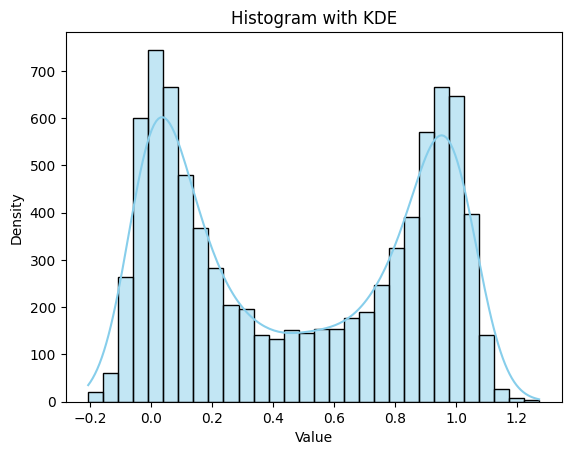

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

res = model.predict(
    df_features[side_features_col][df_label_side["bin"].astype(int) != 0]
)

sns.histplot(res, kde=True, bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Histogram with KDE")
plt.show()

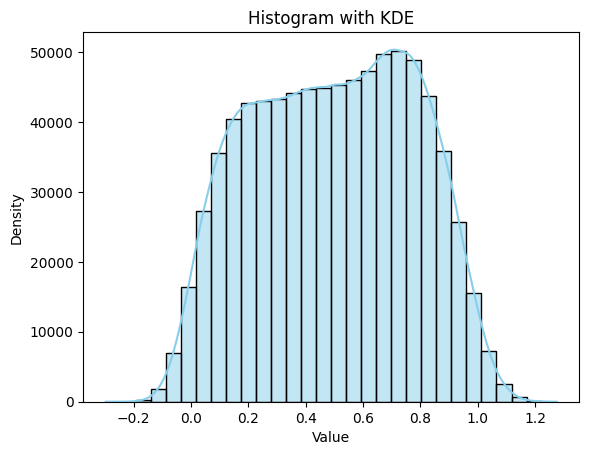

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

res = model.predict(
    df_features[side_features_col][df_label_side["bin"].astype(int) == 0]
)

sns.histplot(res, kde=True, bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Histogram with KDE")
plt.show()

In [16]:
model.save_model("custom_indicators/models/model_side.txt")

# meta model

In [2]:
import pandas as pd

df_feature = pd.read_parquet("data/features_d002.parquet")
df_label = pd.read_parquet("data/label_d002.parquet")
df_label.head()

,close,ret,trgt,bin,side
index,,,,,
2020-01-01 00:00:00+00:00,7177.93,NaN,NaN,0.0,0.0
2020-01-01 00:03:00+00:00,7175.61,NaN,NaN,0.0,0.0
2020-01-01 00:06:00+00:00,7182.06,NaN,NaN,0.0,0.0
2020-01-01 00:09:00+00:00,7183.07,NaN,NaN,0.0,0.0
2020-01-01 00:12:00+00:00,7176.26,NaN,NaN,0.0,0.0


In [3]:
from custom_indicators.selection import META_1M, META_3M, META_15M

invalid_len = 300
date = "2024-09-01"
train_mask = (df_label.index <= date).tolist()
test_mask = (df_label.index > date).tolist()

meta_features_col = META_1M + META_3M + META_15M

train_feature = df_feature[train_mask][meta_features_col].iloc[invalid_len:]
train_label = df_label[train_mask].iloc[invalid_len:]
test_feature = df_feature[test_mask][meta_features_col].iloc[invalid_len:]
test_label = df_label[test_mask].iloc[invalid_len:]

print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

valid_train = train_label["ret"].notna().tolist()
valid_test = test_label["ret"].notna().tolist()

train_feature = train_feature[valid_train]
train_label = train_label[valid_train]["bin"].astype(int)
test_feature = test_feature[valid_test]
test_label = test_label[valid_test]["bin"].astype(int)

print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

test_label.value_counts()

(818101, 696)
(818101, 5)
(72659, 696)
(72659, 5)
(613257, 696)
(613257,)
(54596, 696)
(54596,)


bin
1    29437
0    25159
Name: count, dtype: int64

In [4]:
import lightgbm as lgb
import optuna
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score


def objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "num_threads": -1,
        "verbose": -1,
        "early_stopping_round": 50,
        "boosting": "gbdt",
        "num_leaves": trial.suggest_int("num_leaves", 31, 300),
        "max_depth": trial.suggest_int("max_depth", 30, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 1e-6, 1),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-4, 1),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-4, 1),
    }
    dtrain = lgb.Dataset(train_feature, train_label)
    dtest = lgb.Dataset(test_feature, test_label)
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtest],
        num_boost_round=trial.suggest_int("num_boost_round", 100, 1000),
    )
    pred_proba = model.predict(test_feature)
    pred_label = (pred_proba > 0.5).astype(int)
    precision = precision_score(test_label, pred_label)
    recall = recall_score(test_label, pred_label)
    f1 = f1_score(test_label, pred_label)
    auc = roc_auc_score(test_label, pred_proba)
    print(f"precision: {precision}, recall: {recall}, f1: {f1}")
    return auc


study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=2),
    sampler=optuna.samplers.TPESampler(),
)
study.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=1)

/opt/homebrew/Caskroom/miniforge/base/envs/jesse/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/2g/md1t2j7s6hjdjc5jlvkmn7_c0000gn/T/ipykernel_87620/1575565261.py:41: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=2),
[I 2025-02-18 21:11:15,430] A new study created in memory with name: no-name-4000899a-9aa4-4838-97f6-04c20060aef7
Best trial: 0. Best value: 0.68902:   2%|▏         | 1/50 [00:29<24:28, 29.98s/it]

precision: 0.6565762689605358, recall: 0.6793491184563645, f1: 0.6677685950413224
[I 2025-02-18 21:11:45,454] Trial 0 finished with value: 0.6890202492600234 and parameters: {'num_leaves': 81, 'max_depth': 85, 'min_gain_to_split': 0.7917527471138395, 'min_data_in_leaf': 198, 'lambda_l1': 0.8427185218316733, 'lambda_l2': 0.9585872286427635, 'num_boost_round': 964}. Best is trial 0 with value: 0.6890202492600234.


Best trial: 1. Best value: 0.68924:   4%|▍         | 2/50 [01:16<31:57, 39.96s/it]

precision: 0.6694607331726445, recall: 0.6321636036280871, f1: 0.6502778068979977
[I 2025-02-18 21:12:32,396] Trial 1 finished with value: 0.6892401713423447 and parameters: {'num_leaves': 164, 'max_depth': 36, 'min_gain_to_split': 0.5755777955102471, 'min_data_in_leaf': 84, 'lambda_l1': 0.540739611721992, 'lambda_l2': 0.1449106139036297, 'num_boost_round': 969}. Best is trial 1 with value: 0.6892401713423447.


Best trial: 2. Best value: 0.691876:   6%|▌         | 3/50 [02:11<36:27, 46.55s/it]

precision: 0.6693261148311725, recall: 0.6383802697285729, f1: 0.6534870377132127
[I 2025-02-18 21:13:26,786] Trial 2 finished with value: 0.6918757054354673 and parameters: {'num_leaves': 127, 'max_depth': 47, 'min_gain_to_split': 0.5306057619898616, 'min_data_in_leaf': 116, 'lambda_l1': 0.554641268131765, 'lambda_l2': 0.1434582185498008, 'num_boost_round': 310}. Best is trial 2 with value: 0.6918757054354673.


Best trial: 2. Best value: 0.691876:   8%|▊         | 4/50 [02:50<33:35, 43.81s/it]

precision: 0.6566767331932774, recall: 0.6795869144274213, f1: 0.6679354267875328
[I 2025-02-18 21:14:06,395] Trial 3 finished with value: 0.6883825440163532 and parameters: {'num_leaves': 132, 'max_depth': 36, 'min_gain_to_split': 0.8936691079046796, 'min_data_in_leaf': 101, 'lambda_l1': 0.6335591756891258, 'lambda_l2': 0.14929091084353477, 'num_boost_round': 269}. Best is trial 2 with value: 0.6918757054354673.


Best trial: 2. Best value: 0.691876:  10%|█         | 5/50 [03:44<35:37, 47.50s/it]

precision: 0.6616417705906537, recall: 0.6560451132927948, f1: 0.6588315565031982
[I 2025-02-18 21:15:00,449] Trial 4 finished with value: 0.6860429670894024 and parameters: {'num_leaves': 300, 'max_depth': 54, 'min_gain_to_split': 0.637192406835578, 'min_data_in_leaf': 44, 'lambda_l1': 0.46331427226958455, 'lambda_l2': 0.04326491706323786, 'num_boost_round': 523}. Best is trial 2 with value: 0.6918757054354673.


Best trial: 2. Best value: 0.691876:  12%|█▏        | 6/50 [04:38<36:27, 49.72s/it]

precision: 0.6613229892554323, recall: 0.6544484832014131, f1: 0.6578677776260073
[I 2025-02-18 21:15:54,463] Trial 5 finished with value: 0.6870158210805469 and parameters: {'num_leaves': 285, 'max_depth': 57, 'min_gain_to_split': 0.13771217274872402, 'min_data_in_leaf': 40, 'lambda_l1': 0.30786282903647777, 'lambda_l2': 0.42327472770997354, 'num_boost_round': 175}. Best is trial 2 with value: 0.6918757054354673.


Best trial: 2. Best value: 0.691876:  14%|█▍        | 7/50 [05:23<34:24, 48.02s/it]

precision: 0.6582084582084582, recall: 0.6714678805584808, f1: 0.6647720584525871
[I 2025-02-18 21:16:38,983] Trial 6 finished with value: 0.687953185191312 and parameters: {'num_leaves': 171, 'max_depth': 96, 'min_gain_to_split': 0.966202295483813, 'min_data_in_leaf': 111, 'lambda_l1': 0.9156796681869108, 'lambda_l2': 0.6705967270031794, 'num_boost_round': 177}. Best is trial 2 with value: 0.6918757054354673.


Best trial: 2. Best value: 0.691876:  16%|█▌        | 8/50 [06:01<31:24, 44.88s/it]

precision: 0.6498582291532414, recall: 0.6851581343207528, f1: 0.6670414895903957
[I 2025-02-18 21:17:17,145] Trial 7 finished with value: 0.6839690268671694 and parameters: {'num_leaves': 224, 'max_depth': 91, 'min_gain_to_split': 0.7407460763169548, 'min_data_in_leaf': 91, 'lambda_l1': 0.03549037601081525, 'lambda_l2': 0.7451973327462315, 'num_boost_round': 421}. Best is trial 2 with value: 0.6918757054354673.


Best trial: 2. Best value: 0.691876:  18%|█▊        | 9/50 [07:03<34:13, 50.09s/it]

precision: 0.6641045877226092, recall: 0.6574718891191358, f1: 0.6607715944008193
[I 2025-02-18 21:18:18,679] Trial 8 finished with value: 0.6902397575147308 and parameters: {'num_leaves': 208, 'max_depth': 35, 'min_gain_to_split': 0.9226800099111704, 'min_data_in_leaf': 29, 'lambda_l1': 0.5317320925097996, 'lambda_l2': 0.6755114809366244, 'num_boost_round': 353}. Best is trial 2 with value: 0.6918757054354673.


Best trial: 2. Best value: 0.691876:  20%|██        | 10/50 [07:39<30:36, 45.91s/it]

precision: 0.6563867886987664, recall: 0.6724190644427082, f1: 0.6643062104609602
[I 2025-02-18 21:18:55,243] Trial 9 finished with value: 0.6861247927055922 and parameters: {'num_leaves': 133, 'max_depth': 32, 'min_gain_to_split': 0.31961451765150695, 'min_data_in_leaf': 40, 'lambda_l1': 0.3678294256236341, 'lambda_l2': 0.8993356992037367, 'num_boost_round': 573}. Best is trial 2 with value: 0.6918757054354673.


Best trial: 10. Best value: 0.691968:  22%|██▏       | 11/50 [08:11<27:00, 41.56s/it]

precision: 0.6639375021321597, recall: 0.6611407412440127, f1: 0.662536170212766
[I 2025-02-18 21:19:26,941] Trial 10 finished with value: 0.6919676754540042 and parameters: {'num_leaves': 38, 'max_depth': 73, 'min_gain_to_split': 0.3879672537348536, 'min_data_in_leaf': 158, 'lambda_l1': 0.136658983007942, 'lambda_l2': 0.36336111233964385, 'num_boost_round': 763}. Best is trial 10 with value: 0.6919676754540042.


Best trial: 10. Best value: 0.691968:  24%|██▍       | 12/50 [08:47<25:11, 39.77s/it]

precision: 0.6589068825910931, recall: 0.6634507592485648, f1: 0.661171014100242
[I 2025-02-18 21:20:02,599] Trial 11 finished with value: 0.6882614478294377 and parameters: {'num_leaves': 48, 'max_depth': 74, 'min_gain_to_split': 0.3854201912747225, 'min_data_in_leaf': 158, 'lambda_l1': 0.05557829714573319, 'lambda_l2': 0.35609327510001587, 'num_boost_round': 756}. Best is trial 10 with value: 0.6919676754540042.


Best trial: 10. Best value: 0.691968:  26%|██▌       | 13/50 [09:43<27:33, 44.68s/it]

precision: 0.6668536961705709, recall: 0.6459897408023916, f1: 0.6562559315307231
[I 2025-02-18 21:20:58,594] Trial 12 finished with value: 0.6910727340645411 and parameters: {'num_leaves': 43, 'max_depth': 71, 'min_gain_to_split': 0.4206101608917988, 'min_data_in_leaf': 142, 'lambda_l1': 0.19480779311313495, 'lambda_l2': 0.2996810687196766, 'num_boost_round': 739}. Best is trial 10 with value: 0.6919676754540042.


Best trial: 10. Best value: 0.691968:  28%|██▊       | 14/50 [10:17<24:52, 41.45s/it]

precision: 0.6578363521970926, recall: 0.6748649658592927, f1: 0.6662418673284594
[I 2025-02-18 21:21:32,567] Trial 13 finished with value: 0.687359267768208 and parameters: {'num_leaves': 86, 'max_depth': 49, 'min_gain_to_split': 0.19727926812930435, 'min_data_in_leaf': 150, 'lambda_l1': 0.6570792697413799, 'lambda_l2': 0.22647903233924516, 'num_boost_round': 743}. Best is trial 10 with value: 0.6919676754540042.


Best trial: 10. Best value: 0.691968:  30%|███       | 15/50 [10:57<23:59, 41.14s/it]

precision: 0.6588717535194705, recall: 0.6661684274892142, f1: 0.6625
[I 2025-02-18 21:22:12,988] Trial 14 finished with value: 0.6885319899798799 and parameters: {'num_leaves': 87, 'max_depth': 65, 'min_gain_to_split': 0.5210214599079325, 'min_data_in_leaf': 185, 'lambda_l1': 0.7751864059558187, 'lambda_l2': 0.5568026452319096, 'num_boost_round': 624}. Best is trial 10 with value: 0.6919676754540042.


Best trial: 10. Best value: 0.691968:  32%|███▏      | 16/50 [11:40<23:39, 41.76s/it]

precision: 0.6585842257695157, recall: 0.6643340014267758, f1: 0.66144661852497
[I 2025-02-18 21:22:56,203] Trial 15 finished with value: 0.6893724428448499 and parameters: {'num_leaves': 128, 'max_depth': 48, 'min_gain_to_split': 0.29443445560619474, 'min_data_in_leaf': 127, 'lambda_l1': 0.20161578124771712, 'lambda_l2': 0.029229380513237674, 'num_boost_round': 859}. Best is trial 10 with value: 0.6919676754540042.


Best trial: 10. Best value: 0.691968:  34%|███▍      | 17/50 [12:17<22:06, 40.21s/it]

precision: 0.6613191934884664, recall: 0.6651832727519787, f1: 0.6632456051214307
[I 2025-02-18 21:23:32,808] Trial 16 finished with value: 0.691293126707786 and parameters: {'num_leaves': 36, 'max_depth': 79, 'min_gain_to_split': 0.005321818259216904, 'min_data_in_leaf': 173, 'lambda_l1': 0.39412203408205043, 'lambda_l2': 0.4915509344184912, 'num_boost_round': 396}. Best is trial 10 with value: 0.6919676754540042.


Best trial: 10. Best value: 0.691968:  36%|███▌      | 18/50 [12:57<21:23, 40.12s/it]

precision: 0.6577556209850107, recall: 0.6678329992866121, f1: 0.66275600505689
[I 2025-02-18 21:24:12,723] Trial 17 finished with value: 0.6859157225548113 and parameters: {'num_leaves': 242, 'max_depth': 63, 'min_gain_to_split': 0.6881710555881951, 'min_data_in_leaf': 73, 'lambda_l1': 0.1649418094657704, 'lambda_l2': 0.25810910333595527, 'num_boost_round': 106}. Best is trial 10 with value: 0.6919676754540042.


Best trial: 10. Best value: 0.691968:  38%|███▊      | 19/50 [13:38<20:51, 40.37s/it]

precision: 0.6629020039942153, recall: 0.6540068621123076, f1: 0.6584243916619641
[I 2025-02-18 21:24:53,657] Trial 18 finished with value: 0.689105793455218 and parameters: {'num_leaves': 105, 'max_depth': 42, 'min_gain_to_split': 0.474676851586832, 'min_data_in_leaf': 122, 'lambda_l1': 0.6355931406985299, 'lambda_l2': 0.1383971445138285, 'num_boost_round': 490}. Best is trial 10 with value: 0.6919676754540042.


Best trial: 10. Best value: 0.691968:  40%|████      | 20/50 [14:21<20:40, 41.35s/it]

precision: 0.6596807725839984, recall: 0.6683085912287258, f1: 0.663966654854115
[I 2025-02-18 21:25:37,296] Trial 19 finished with value: 0.6891633018061251 and parameters: {'num_leaves': 168, 'max_depth': 57, 'min_gain_to_split': 0.5816461329759267, 'min_data_in_leaf': 168, 'lambda_l1': 0.29939746299968417, 'lambda_l2': 0.40286597740034, 'num_boost_round': 668}. Best is trial 10 with value: 0.6919676754540042.


Best trial: 20. Best value: 0.692977:  42%|████▏     | 21/50 [15:09<20:52, 43.18s/it]

precision: 0.6650652492418822, recall: 0.6630770798654754, f1: 0.6640696764535774
[I 2025-02-18 21:26:24,755] Trial 20 finished with value: 0.692976943569293 and parameters: {'num_leaves': 65, 'max_depth': 66, 'min_gain_to_split': 0.24292379824662352, 'min_data_in_leaf': 135, 'lambda_l1': 0.7549239443080835, 'lambda_l2': 0.5397665779330011, 'num_boost_round': 845}. Best is trial 20 with value: 0.692976943569293.


Best trial: 20. Best value: 0.692977:  44%|████▍     | 22/50 [15:40<18:26, 39.51s/it]

precision: 0.6568850964043773, recall: 0.6851581343207528, f1: 0.6707237990721804
[I 2025-02-18 21:26:55,713] Trial 21 finished with value: 0.6919716526052239 and parameters: {'num_leaves': 62, 'max_depth': 67, 'min_gain_to_split': 0.2294774695655032, 'min_data_in_leaf': 133, 'lambda_l1': 0.758977452148154, 'lambda_l2': 0.5439811090546989, 'num_boost_round': 853}. Best is trial 20 with value: 0.692976943569293.


Best trial: 22. Best value: 0.693633:  46%|████▌     | 23/50 [16:24<18:26, 40.98s/it]

precision: 0.6672308967804339, recall: 0.6561470258518192, f1: 0.6616425451742742
[I 2025-02-18 21:27:40,123] Trial 22 finished with value: 0.6936325706354514 and parameters: {'num_leaves': 67, 'max_depth': 72, 'min_gain_to_split': 0.19185058307414762, 'min_data_in_leaf': 135, 'lambda_l1': 0.9743571998948695, 'lambda_l2': 0.5847257017719867, 'num_boost_round': 860}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  48%|████▊     | 24/50 [16:55<16:26, 37.95s/it]

precision: 0.6583341632639511, recall: 0.6736759860040086, f1: 0.6659167226326393
[I 2025-02-18 21:28:10,999] Trial 23 finished with value: 0.6881217006868959 and parameters: {'num_leaves': 65, 'max_depth': 66, 'min_gain_to_split': 0.12712981042756571, 'min_data_in_leaf': 139, 'lambda_l1': 0.9990195522034475, 'lambda_l2': 0.5582906176385088, 'num_boost_round': 874}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  50%|█████     | 25/50 [17:26<14:54, 35.78s/it]

precision: 0.6582448993001938, recall: 0.6806060400176649, f1: 0.6692387346761532
[I 2025-02-18 21:28:41,724] Trial 24 finished with value: 0.6899075739086851 and parameters: {'num_leaves': 61, 'max_depth': 81, 'min_gain_to_split': 0.013025572273057867, 'min_data_in_leaf': 133, 'lambda_l1': 0.7667653637661727, 'lambda_l2': 0.7911565436214499, 'num_boost_round': 881}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  52%|█████▏    | 26/50 [18:13<15:42, 39.26s/it]

precision: 0.6643140559710664, recall: 0.642694568060604, f1: 0.653325505905104
[I 2025-02-18 21:29:29,088] Trial 25 finished with value: 0.6895372458375386 and parameters: {'num_leaves': 110, 'max_depth': 69, 'min_gain_to_split': 0.23677559738283105, 'min_data_in_leaf': 68, 'lambda_l1': 0.8716897248933504, 'lambda_l2': 0.5778803824897784, 'num_boost_round': 829}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  54%|█████▍    | 27/50 [18:44<14:06, 36.83s/it]

precision: 0.6589090667640517, recall: 0.6742195196521384, f1: 0.666476375969643
[I 2025-02-18 21:30:00,240] Trial 26 finished with value: 0.6901604744127988 and parameters: {'num_leaves': 67, 'max_depth': 60, 'min_gain_to_split': 0.10306776892455755, 'min_data_in_leaf': 100, 'lambda_l1': 0.9878687960980538, 'lambda_l2': 0.4912814632694086, 'num_boost_round': 987}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  56%|█████▌    | 28/50 [19:24<13:47, 37.63s/it]

precision: 0.6660627177700349, recall: 0.6493868261032034, f1: 0.6576190721915476
[I 2025-02-18 21:30:39,751] Trial 27 finished with value: 0.6882828573387703 and parameters: {'num_leaves': 109, 'max_depth': 79, 'min_gain_to_split': 0.24927298230716394, 'min_data_in_leaf': 146, 'lambda_l1': 0.7664835848485843, 'lambda_l2': 0.6458441424335284, 'num_boost_round': 684}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  58%|█████▊    | 29/50 [20:05<13:32, 38.71s/it]

precision: 0.6671136324565927, recall: 0.6591364609165337, f1: 0.6631010560131233
[I 2025-02-18 21:31:20,981] Trial 28 finished with value: 0.6907572381556348 and parameters: {'num_leaves': 93, 'max_depth': 85, 'min_gain_to_split': 0.18315106745277793, 'min_data_in_leaf': 129, 'lambda_l1': 0.7012589881506985, 'lambda_l2': 0.8007735998413881, 'num_boost_round': 913}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  60%|██████    | 30/50 [20:36<12:09, 36.47s/it]

precision: 0.6607849001428904, recall: 0.675510412066447, f1: 0.6680665210818075
[I 2025-02-18 21:31:52,214] Trial 29 finished with value: 0.6913993492538051 and parameters: {'num_leaves': 69, 'max_depth': 76, 'min_gain_to_split': 0.3130854551512343, 'min_data_in_leaf': 176, 'lambda_l1': 0.844038047492912, 'lambda_l2': 0.6200249168815326, 'num_boost_round': 799}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  62%|██████▏   | 31/50 [21:16<11:51, 37.44s/it]

precision: 0.6616592231695764, recall: 0.6643340014267758, f1: 0.6629939145322327
[I 2025-02-18 21:32:31,911] Trial 30 finished with value: 0.6894234065507181 and parameters: {'num_leaves': 153, 'max_depth': 83, 'min_gain_to_split': 0.06001945408882442, 'min_data_in_leaf': 108, 'lambda_l1': 0.9218689314456919, 'lambda_l2': 0.9163840636998284, 'num_boost_round': 928}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  64%|██████▍   | 32/50 [21:54<11:17, 37.66s/it]

precision: 0.6626831940830024, recall: 0.6574379182661276, f1: 0.6600501355706758
[I 2025-02-18 21:33:10,083] Trial 31 finished with value: 0.6906010720150177 and parameters: {'num_leaves': 51, 'max_depth': 72, 'min_gain_to_split': 0.4247481347980939, 'min_data_in_leaf': 200, 'lambda_l1': 0.7196717527364598, 'lambda_l2': 0.44410299367078976, 'num_boost_round': 808}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  66%|██████▌   | 33/50 [22:29<10:23, 36.69s/it]

precision: 0.6650071371374856, recall: 0.6488772633080817, f1: 0.6568431911966988
[I 2025-02-18 21:33:44,510] Trial 32 finished with value: 0.6900468774952346 and parameters: {'num_leaves': 35, 'max_depth': 88, 'min_gain_to_split': 0.35193294617514737, 'min_data_in_leaf': 160, 'lambda_l1': 0.8130962358586219, 'lambda_l2': 0.34487372058819243, 'num_boost_round': 951}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  68%|██████▊   | 34/50 [22:58<09:11, 34.46s/it]

precision: 0.6608716200249806, recall: 0.6650473893399463, f1: 0.6629529292245174
[I 2025-02-18 21:34:13,761] Trial 33 finished with value: 0.6888756027478667 and parameters: {'num_leaves': 31, 'max_depth': 68, 'min_gain_to_split': 0.2505629198815945, 'min_data_in_leaf': 162, 'lambda_l1': 0.9083557378472815, 'lambda_l2': 0.49675999847765523, 'num_boost_round': 706}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  70%|███████   | 35/50 [23:26<08:08, 32.55s/it]

precision: 0.6532081074102762, recall: 0.6875360940313211, f1: 0.6699326393141457
[I 2025-02-18 21:34:41,862] Trial 34 finished with value: 0.6872657233621913 and parameters: {'num_leaves': 77, 'max_depth': 76, 'min_gain_to_split': 0.1826143200903461, 'min_data_in_leaf': 153, 'lambda_l1': 0.6088905862472672, 'lambda_l2': 0.5988466795787175, 'num_boost_round': 774}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  72%|███████▏  | 36/50 [24:07<08:12, 35.18s/it]

precision: 0.6686067019400352, recall: 0.6439175187688962, f1: 0.6560299029193417
[I 2025-02-18 21:35:23,186] Trial 35 finished with value: 0.6935227780375479 and parameters: {'num_leaves': 54, 'max_depth': 62, 'min_gain_to_split': 0.4481980385835329, 'min_data_in_leaf': 187, 'lambda_l1': 0.44123269462378406, 'lambda_l2': 0.6980034377874219, 'num_boost_round': 997}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  74%|███████▍  | 37/50 [24:44<07:41, 35.52s/it]

precision: 0.6655455263067578, recall: 0.6587627815334443, f1: 0.6621367842387408
[I 2025-02-18 21:35:59,483] Trial 36 finished with value: 0.6933780505105982 and parameters: {'num_leaves': 54, 'max_depth': 63, 'min_gain_to_split': 0.4697827663119387, 'min_data_in_leaf': 118, 'lambda_l1': 0.46743948966084276, 'lambda_l2': 0.7152608284610955, 'num_boost_round': 996}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  76%|███████▌  | 38/50 [25:24<07:24, 37.07s/it]

precision: 0.6691610870421426, recall: 0.6348812718687367, f1: 0.651570616741624
[I 2025-02-18 21:36:40,187] Trial 37 finished with value: 0.6886184800227843 and parameters: {'num_leaves': 97, 'max_depth': 52, 'min_gain_to_split': 0.5822835245268393, 'min_data_in_leaf': 188, 'lambda_l1': 0.44754950523333575, 'lambda_l2': 0.7436377558117615, 'num_boost_round': 998}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  78%|███████▊  | 39/50 [25:58<06:36, 36.05s/it]

precision: 0.6628441941907574, recall: 0.6558412881747461, f1: 0.6593241466454929
[I 2025-02-18 21:37:13,843] Trial 38 finished with value: 0.6899612367574113 and parameters: {'num_leaves': 80, 'max_depth': 61, 'min_gain_to_split': 0.8381881404280378, 'min_data_in_leaf': 118, 'lambda_l1': 0.5715419999498171, 'lambda_l2': 0.7157215027483043, 'num_boost_round': 924}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  80%|████████  | 40/50 [26:32<05:53, 35.40s/it]

precision: 0.656194661244835, recall: 0.6797567686924618, f1: 0.6677679331230916
[I 2025-02-18 21:37:47,725] Trial 39 finished with value: 0.688271658393866 and parameters: {'num_leaves': 146, 'max_depth': 56, 'min_gain_to_split': 0.4760989102404155, 'min_data_in_leaf': 87, 'lambda_l1': 0.4841403198977756, 'lambda_l2': 0.8276257014000808, 'num_boost_round': 969}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  82%|████████▏ | 41/50 [27:12<05:30, 36.73s/it]

precision: 0.662614913176711, recall: 0.6611067703910045, f1: 0.6618599826551261
[I 2025-02-18 21:38:27,559] Trial 40 finished with value: 0.6899166185352155 and parameters: {'num_leaves': 121, 'max_depth': 61, 'min_gain_to_split': 0.6582656517269799, 'min_data_in_leaf': 102, 'lambda_l1': 0.3155466671984165, 'lambda_l2': 0.6962156079877516, 'num_boost_round': 897}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  84%|████████▍ | 42/50 [28:02<05:25, 40.70s/it]

precision: 0.6624982679783844, recall: 0.6496925637802765, f1: 0.6560329302804219
[I 2025-02-18 21:39:17,519] Trial 41 finished with value: 0.6890576045060147 and parameters: {'num_leaves': 186, 'max_depth': 67, 'min_gain_to_split': 0.27869193197794884, 'min_data_in_leaf': 115, 'lambda_l1': 0.4093631970078465, 'lambda_l2': 0.5455446761668449, 'num_boost_round': 847}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  86%|████████▌ | 43/50 [28:36<04:31, 38.72s/it]

precision: 0.662938589013537, recall: 0.6604613241838503, f1: 0.6616976380096657
[I 2025-02-18 21:39:51,607] Trial 42 finished with value: 0.6903588614128584 and parameters: {'num_leaves': 51, 'max_depth': 64, 'min_gain_to_split': 0.350808385168486, 'min_data_in_leaf': 136, 'lambda_l1': 0.5181500133999519, 'lambda_l2': 0.9994364683766693, 'num_boost_round': 951}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  88%|████████▊ | 44/50 [29:17<03:57, 39.56s/it]

precision: 0.665295020225973, recall: 0.648095933688895, f1: 0.656582864419321
[I 2025-02-18 21:40:33,150] Trial 43 finished with value: 0.6893496911904444 and parameters: {'num_leaves': 57, 'max_depth': 52, 'min_gain_to_split': 0.4403617742707369, 'min_data_in_leaf': 124, 'lambda_l1': 0.5687085322365344, 'lambda_l2': 0.6298472541429465, 'num_boost_round': 993}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  90%|█████████ | 45/50 [29:48<03:04, 36.92s/it]

precision: 0.6602486963497793, recall: 0.6709922886163672, f1: 0.6655771401614071
[I 2025-02-18 21:41:03,890] Trial 44 finished with value: 0.6900096282435977 and parameters: {'num_leaves': 74, 'max_depth': 59, 'min_gain_to_split': 0.08434856115150036, 'min_data_in_leaf': 95, 'lambda_l1': 0.7028567489010148, 'lambda_l2': 0.8549472694359694, 'num_boost_round': 825}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  92%|█████████▏| 46/50 [30:16<02:16, 34.15s/it]

precision: 0.6561699367601751, recall: 0.6873322689132724, f1: 0.6713897000265463
[I 2025-02-18 21:41:31,576] Trial 45 finished with value: 0.6886470188339127 and parameters: {'num_leaves': 56, 'max_depth': 69, 'min_gain_to_split': 0.17810342267528176, 'min_data_in_leaf': 189, 'lambda_l1': 0.9498753217365097, 'lambda_l2': 0.7486656707128823, 'num_boost_round': 902}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  94%|█████████▍| 47/50 [30:47<01:39, 33.23s/it]

precision: 0.6615776935207865, recall: 0.669803308761083, f1: 0.6656650911546252
[I 2025-02-18 21:42:02,650] Trial 46 finished with value: 0.688333279595771 and parameters: {'num_leaves': 46, 'max_depth': 41, 'min_gain_to_split': 0.35930249442314627, 'min_data_in_leaf': 71, 'lambda_l1': 0.45560699486222594, 'lambda_l2': 0.4486330621392857, 'num_boost_round': 616}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  96%|█████████▌| 48/50 [31:16<01:04, 32.19s/it]

precision: 0.6545484186501467, recall: 0.6819648741379896, f1: 0.6679754437919044
[I 2025-02-18 21:42:32,430] Trial 47 finished with value: 0.6883716637296351 and parameters: {'num_leaves': 98, 'max_depth': 54, 'min_gain_to_split': 0.56464793270635, 'min_data_in_leaf': 147, 'lambda_l1': 0.34823848688575343, 'lambda_l2': 0.6816750476837917, 'num_boost_round': 942}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633:  98%|█████████▊| 49/50 [32:10<00:38, 38.48s/it]

precision: 0.6640681342079054, recall: 0.6568943846179978, f1: 0.6604617801762416
[I 2025-02-18 21:43:25,568] Trial 48 finished with value: 0.6897916201357639 and parameters: {'num_leaves': 252, 'max_depth': 71, 'min_gain_to_split': 0.21429477797519753, 'min_data_in_leaf': 60, 'lambda_l1': 0.2631006688269282, 'lambda_l2': 0.5177630673698519, 'num_boost_round': 855}. Best is trial 22 with value: 0.6936325706354514.


Best trial: 22. Best value: 0.693633: 100%|██████████| 50/50 [32:54<00:00, 39.50s/it]

precision: 0.665810214923093, recall: 0.6514250772836906, f1: 0.6585390981833167
[I 2025-02-18 21:44:10,291] Trial 49 finished with value: 0.6908376939466974 and parameters: {'num_leaves': 76, 'max_depth': 75, 'min_gain_to_split': 0.1464913951589302, 'min_data_in_leaf': 108, 'lambda_l1': 0.5922931689963664, 'lambda_l2': 0.6541485525643781, 'num_boost_round': 773}. Best is trial 22 with value: 0.6936325706354514.


In [8]:
model = lgb.train(
    study.best_params,
    lgb.Dataset(train_feature, train_label),
)

In [15]:
model.save_model("custom_indicators/model_meta.txt")

# side models

In [17]:
from custom_indicators.selection import SIDE_1M, SIDE_3M, SIDE_15M

invalid_len = 300
date = "2024-09-01"
train_mask = (df_label.index <= date).tolist()
test_mask = (df_label.index > date).tolist()

side_features_col = SIDE_1M + SIDE_3M + SIDE_15M

train_feature = df_feature[train_mask][side_features_col].iloc[invalid_len:]
train_label = df_label[train_mask].iloc[invalid_len:]
test_feature = df_feature[test_mask][side_features_col].iloc[invalid_len:]
test_label = df_label[test_mask].iloc[invalid_len:]

print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

valid_train = (train_label["side"].astype(int) != 0).tolist()
valid_test = (test_label["side"].astype(int) != 0).tolist()

train_feature = train_feature[valid_train]
train_label = (train_label[valid_train]["side"].astype(int) == 1).astype(int)
test_feature = test_feature[valid_test]
test_label = (test_label[valid_test]["side"].astype(int) == 1).astype(int)

print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

test_label.value_counts()

(818101, 374)
(818101, 5)
(72659, 374)
(72659, 5)
(318731, 374)
(318731,)
(29437, 374)
(29437,)


side
1    14791
0    14646
Name: count, dtype: int64

In [18]:
import lightgbm as lgb
import optuna
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score


def objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "num_threads": -1,
        "verbose": -1,
        "early_stopping_round": 50,
        "boosting": "gbdt",
        "num_leaves": trial.suggest_int("num_leaves", 31, 300),
        "max_depth": trial.suggest_int("max_depth", 30, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 1e-6, 1),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-4, 1),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-4, 1),
    }
    dtrain = lgb.Dataset(train_feature, train_label)
    dtest = lgb.Dataset(test_feature, test_label)
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtest],
        num_boost_round=trial.suggest_int("num_boost_round", 100, 1000),
    )
    pred_proba = model.predict(test_feature)
    pred_label = (pred_proba > 0.5).astype(int)
    precision = precision_score(test_label, pred_label)
    recall = recall_score(test_label, pred_label)
    f1 = f1_score(test_label, pred_label)
    auc = roc_auc_score(test_label, pred_proba)
    print(f"precision: {precision}, recall: {recall}, f1: {f1}")
    return auc


study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=2),
    sampler=optuna.samplers.TPESampler(),
)
study.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=1)

/var/folders/2g/md1t2j7s6hjdjc5jlvkmn7_c0000gn/T/ipykernel_87620/1575565261.py:41: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=2),
[I 2025-02-18 21:51:27,671] A new study created in memory with name: no-name-572793ea-48b0-4a09-b24d-8d5342580601
Best trial: 0. Best value: 0.841762:   2%|▏         | 1/50 [00:36<29:34, 36.22s/it]

precision: 0.7506438931815101, recall: 0.7487661415725779, f1: 0.7497038415975631
[I 2025-02-18 21:52:03,891] Trial 0 finished with value: 0.8417623623091695 and parameters: {'num_leaves': 293, 'max_depth': 75, 'min_gain_to_split': 0.4092636149889744, 'min_data_in_leaf': 152, 'lambda_l1': 0.39451378542392707, 'lambda_l2': 0.37463037797800447, 'num_boost_round': 947}. Best is trial 0 with value: 0.8417623623091695.


Best trial: 0. Best value: 0.841762:   4%|▍         | 2/50 [00:44<15:56, 19.93s/it]

precision: 0.7451400992090093, recall: 0.751538097491718, f1: 0.748325423272409
[I 2025-02-18 21:52:12,411] Trial 1 finished with value: 0.8387139198445032 and parameters: {'num_leaves': 47, 'max_depth': 42, 'min_gain_to_split': 0.05279199805084433, 'min_data_in_leaf': 32, 'lambda_l1': 0.7578423457997577, 'lambda_l2': 0.690214657899998, 'num_boost_round': 101}. Best is trial 0 with value: 0.8417623623091695.


Best trial: 2. Best value: 0.842295:   6%|▌         | 3/50 [01:11<17:57, 22.93s/it]

precision: 0.7499493277481252, recall: 0.7504563585964438, f1: 0.7502027575020276
[I 2025-02-18 21:52:38,921] Trial 2 finished with value: 0.8422947333557662 and parameters: {'num_leaves': 248, 'max_depth': 76, 'min_gain_to_split': 0.29278740021895283, 'min_data_in_leaf': 57, 'lambda_l1': 0.12339649771723162, 'lambda_l2': 0.8136853785560002, 'num_boost_round': 852}. Best is trial 2 with value: 0.8422947333557662.


Best trial: 3. Best value: 0.842311:   8%|▊         | 4/50 [01:38<18:58, 24.75s/it]

precision: 0.7493587147293101, recall: 0.7505239672773985, f1: 0.7499408883634521
[I 2025-02-18 21:53:06,448] Trial 3 finished with value: 0.842311203912481 and parameters: {'num_leaves': 142, 'max_depth': 47, 'min_gain_to_split': 0.03233020247614849, 'min_data_in_leaf': 50, 'lambda_l1': 0.5434191043061496, 'lambda_l2': 0.8827573589857444, 'num_boost_round': 870}. Best is trial 3 with value: 0.842311203912481.


Best trial: 3. Best value: 0.842311:  10%|█         | 5/50 [02:03<18:36, 24.80s/it]

precision: 0.7503887499154891, recall: 0.7503887499154891, f1: 0.7503887499154891
[I 2025-02-18 21:53:31,350] Trial 4 finished with value: 0.8420691310441716 and parameters: {'num_leaves': 175, 'max_depth': 64, 'min_gain_to_split': 0.02835040570810048, 'min_data_in_leaf': 59, 'lambda_l1': 0.5835848299074214, 'lambda_l2': 0.6693997290757681, 'num_boost_round': 506}. Best is trial 3 with value: 0.842311203912481.


Best trial: 5. Best value: 0.843272:  12%|█▏        | 6/50 [02:24<17:04, 23.29s/it]

precision: 0.7484200618528977, recall: 0.752619836386992, f1: 0.7505140738243722
[I 2025-02-18 21:53:51,715] Trial 5 finished with value: 0.8432717263422911 and parameters: {'num_leaves': 109, 'max_depth': 65, 'min_gain_to_split': 0.8869268926999727, 'min_data_in_leaf': 161, 'lambda_l1': 0.6374344964129997, 'lambda_l2': 0.40178653965154765, 'num_boost_round': 962}. Best is trial 5 with value: 0.8432717263422911.


Best trial: 5. Best value: 0.843272:  14%|█▍        | 7/50 [02:50<17:26, 24.34s/it]

precision: 0.7472386853448276, recall: 0.7501183151916706, f1: 0.7486757312999763
[I 2025-02-18 21:54:18,220] Trial 6 finished with value: 0.8414760617491881 and parameters: {'num_leaves': 251, 'max_depth': 53, 'min_gain_to_split': 0.0021487795774649304, 'min_data_in_leaf': 50, 'lambda_l1': 0.2137338777648961, 'lambda_l2': 0.18276326898113454, 'num_boost_round': 653}. Best is trial 5 with value: 0.8432717263422911.


Best trial: 5. Best value: 0.843272:  16%|█▌        | 8/50 [03:12<16:25, 23.46s/it]

precision: 0.7502372238037143, recall: 0.7483604894868501, f1: 0.7492976815027923
[I 2025-02-18 21:54:39,790] Trial 7 finished with value: 0.8429996574881258 and parameters: {'num_leaves': 104, 'max_depth': 85, 'min_gain_to_split': 0.5288291624019437, 'min_data_in_leaf': 81, 'lambda_l1': 0.12957293824157895, 'lambda_l2': 0.6437777905343691, 'num_boost_round': 491}. Best is trial 5 with value: 0.8432717263422911.


Best trial: 5. Best value: 0.843272:  18%|█▊        | 9/50 [03:50<19:14, 28.16s/it]

precision: 0.7508669341130074, recall: 0.7466026637820297, f1: 0.7487287273713472
[I 2025-02-18 21:55:18,274] Trial 8 finished with value: 0.8410424540324442 and parameters: {'num_leaves': 300, 'max_depth': 58, 'min_gain_to_split': 0.7322744483223746, 'min_data_in_leaf': 194, 'lambda_l1': 0.4090052895121824, 'lambda_l2': 0.5819777262053304, 'num_boost_round': 488}. Best is trial 5 with value: 0.8432717263422911.


Best trial: 9. Best value: 0.8436:  20%|██        | 10/50 [04:07<16:31, 24.79s/it] 

precision: 0.750185172715642, recall: 0.7532283145155838, f1: 0.7517036637203968
[I 2025-02-18 21:55:35,538] Trial 9 finished with value: 0.8435995125786168 and parameters: {'num_leaves': 74, 'max_depth': 60, 'min_gain_to_split': 0.004785391906105989, 'min_data_in_leaf': 136, 'lambda_l1': 0.6441866637565624, 'lambda_l2': 0.8311039908999416, 'num_boost_round': 208}. Best is trial 9 with value: 0.8435995125786168.


Best trial: 9. Best value: 0.8436:  22%|██▏       | 11/50 [04:16<12:55, 19.88s/it]

precision: 0.7443922095366018, recall: 0.7493746197011696, f1: 0.74687510528621
[I 2025-02-18 21:55:44,278] Trial 10 finished with value: 0.8384862171676324 and parameters: {'num_leaves': 40, 'max_depth': 31, 'min_gain_to_split': 0.21554478184259768, 'min_data_in_leaf': 119, 'lambda_l1': 0.9309256460960271, 'lambda_l2': 0.9820190681301088, 'num_boost_round': 114}. Best is trial 9 with value: 0.8435995125786168.


Best trial: 9. Best value: 0.8436:  24%|██▍       | 12/50 [04:37<12:43, 20.10s/it]

precision: 0.7503030303030302, recall: 0.7532959231965385, f1: 0.7517964980938565
[I 2025-02-18 21:56:04,882] Trial 11 finished with value: 0.8435991248188734 and parameters: {'num_leaves': 98, 'max_depth': 96, 'min_gain_to_split': 0.9448868254333096, 'min_data_in_leaf': 146, 'lambda_l1': 0.743382796984477, 'lambda_l2': 0.33182251480364733, 'num_boost_round': 244}. Best is trial 9 with value: 0.8435995125786168.


Best trial: 12. Best value: 0.843934:  26%|██▌       | 13/50 [04:56<12:17, 19.93s/it]

precision: 0.751126959564018, recall: 0.7547833141775404, f1: 0.7529506980508531
[I 2025-02-18 21:56:24,425] Trial 12 finished with value: 0.8439344031273821 and parameters: {'num_leaves': 87, 'max_depth': 99, 'min_gain_to_split': 0.9848772179167755, 'min_data_in_leaf': 124, 'lambda_l1': 0.9073520138041895, 'lambda_l2': 0.09941551515985647, 'num_boost_round': 283}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  28%|██▊       | 14/50 [05:15<11:48, 19.68s/it]

precision: 0.750706689998654, recall: 0.7541072273679941, f1: 0.7524031164626126
[I 2025-02-18 21:56:43,530] Trial 13 finished with value: 0.8436435371580422 and parameters: {'num_leaves': 67, 'max_depth': 99, 'min_gain_to_split': 0.645997902340429, 'min_data_in_leaf': 109, 'lambda_l1': 0.9916633110723954, 'lambda_l2': 0.06452085830525692, 'num_boost_round': 315}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  30%|███       | 15/50 [05:41<12:36, 21.62s/it]

precision: 0.7522985397512169, recall: 0.7523494016631735, f1: 0.7523239698475476
[I 2025-02-18 21:57:09,657] Trial 14 finished with value: 0.843065964404228 and parameters: {'num_leaves': 162, 'max_depth': 98, 'min_gain_to_split': 0.6886168291895421, 'min_data_in_leaf': 109, 'lambda_l1': 0.9997098487782358, 'lambda_l2': 0.018063361945598752, 'num_boost_round': 348}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  32%|███▏      | 16/50 [06:00<11:39, 20.58s/it]

precision: 0.751263562234652, recall: 0.7537015752822662, f1: 0.752480593992575
[I 2025-02-18 21:57:27,823] Trial 15 finished with value: 0.8434415835746006 and parameters: {'num_leaves': 71, 'max_depth': 88, 'min_gain_to_split': 0.7337903873876852, 'min_data_in_leaf': 96, 'lambda_l1': 0.8425292818513328, 'lambda_l2': 0.05063025223885015, 'num_boost_round': 340}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  34%|███▍      | 17/50 [06:21<11:29, 20.90s/it]

precision: 0.7505396654074474, recall: 0.7522141843012643, f1: 0.7513759918959987
[I 2025-02-18 21:57:49,452] Trial 16 finished with value: 0.8431555461373023 and parameters: {'num_leaves': 136, 'max_depth': 88, 'min_gain_to_split': 0.5900241414297858, 'min_data_in_leaf': 173, 'lambda_l1': 0.9043442953467327, 'lambda_l2': 0.1996871543981497, 'num_boost_round': 635}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  36%|███▌      | 18/50 [06:49<12:16, 23.02s/it]

precision: 0.7492078473673566, recall: 0.751335271448854, f1: 0.7502700513097489
[I 2025-02-18 21:58:17,409] Trial 17 finished with value: 0.8429264401394557 and parameters: {'num_leaves': 181, 'max_depth': 100, 'min_gain_to_split': 0.8441061869551243, 'min_data_in_leaf': 124, 'lambda_l1': 0.9980937238857258, 'lambda_l2': 0.16072857599796803, 'num_boost_round': 347}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  38%|███▊      | 19/50 [07:07<11:02, 21.36s/it]

precision: 0.7488891880974822, recall: 0.752078966939355, f1: 0.7504806881430258
[I 2025-02-18 21:58:34,907] Trial 18 finished with value: 0.8429499734629233 and parameters: {'num_leaves': 66, 'max_depth': 75, 'min_gain_to_split': 0.9825769191654268, 'min_data_in_leaf': 89, 'lambda_l1': 0.7802271990896247, 'lambda_l2': 0.29416475281276766, 'num_boost_round': 242}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  40%|████      | 20/50 [07:32<11:12, 22.43s/it]

precision: 0.750474126253048, recall: 0.7491041849773511, f1: 0.7497885298595838
[I 2025-02-18 21:58:59,817] Trial 19 finished with value: 0.8412923097927439 and parameters: {'num_leaves': 205, 'max_depth': 81, 'min_gain_to_split': 0.38955216896421885, 'min_data_in_leaf': 80, 'lambda_l1': 0.8642499756771989, 'lambda_l2': 0.4874587921658501, 'num_boost_round': 418}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  42%|████▏     | 21/50 [07:50<10:14, 21.18s/it]

precision: 0.7498656636217088, recall: 0.7547833141775404, f1: 0.7523164527106708
[I 2025-02-18 21:59:18,082] Trial 20 finished with value: 0.8434556767947942 and parameters: {'num_leaves': 35, 'max_depth': 93, 'min_gain_to_split': 0.8238864155008785, 'min_data_in_leaf': 103, 'lambda_l1': 0.393883017251644, 'lambda_l2': 0.09662991196079232, 'num_boost_round': 685}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  44%|████▍     | 22/50 [08:08<09:26, 20.22s/it]

precision: 0.7491056361795477, recall: 0.7503211412345345, f1: 0.7497128960345876
[I 2025-02-18 21:59:36,061] Trial 21 finished with value: 0.8427373241732294 and parameters: {'num_leaves': 78, 'max_depth': 66, 'min_gain_to_split': 0.15890269168317447, 'min_data_in_leaf': 133, 'lambda_l1': 0.6938546637006568, 'lambda_l2': 0.5098639719683464, 'num_boost_round': 220}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  46%|████▌     | 23/50 [08:27<08:53, 19.78s/it]

precision: 0.7503046716316859, recall: 0.7492394023392603, f1: 0.7497716586042421
[I 2025-02-18 21:59:54,806] Trial 22 finished with value: 0.8435486421932474 and parameters: {'num_leaves': 126, 'max_depth': 91, 'min_gain_to_split': 0.6507240368201532, 'min_data_in_leaf': 137, 'lambda_l1': 0.8251377925862903, 'lambda_l2': 0.2583371684780832, 'num_boost_round': 182}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  48%|████▊     | 24/50 [08:48<08:46, 20.23s/it]

precision: 0.7511638890763106, recall: 0.7526874450679467, f1: 0.7519248953127111
[I 2025-02-18 22:00:16,105] Trial 23 finished with value: 0.8433298395257226 and parameters: {'num_leaves': 83, 'max_depth': 81, 'min_gain_to_split': 0.48189290999051204, 'min_data_in_leaf': 173, 'lambda_l1': 0.6602708998800106, 'lambda_l2': 0.12385037206918695, 'num_boost_round': 319}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  50%|█████     | 25/50 [09:07<08:17, 19.90s/it]

precision: 0.7507924731908006, recall: 0.752619836386992, f1: 0.7517050442298602
[I 2025-02-18 22:00:35,229] Trial 24 finished with value: 0.8436999885140025 and parameters: {'num_leaves': 51, 'max_depth': 58, 'min_gain_to_split': 0.2818764732266611, 'min_data_in_leaf': 118, 'lambda_l1': 0.4814204206484296, 'lambda_l2': 0.004513248692684248, 'num_boost_round': 418}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  52%|█████▏    | 26/50 [09:28<08:05, 20.22s/it]

precision: 0.7499158985399986, recall: 0.753566357920357, f1: 0.7517366965670735
[I 2025-02-18 22:00:56,211] Trial 25 finished with value: 0.8433639300698199 and parameters: {'num_leaves': 50, 'max_depth': 70, 'min_gain_to_split': 0.31620262840248103, 'min_data_in_leaf': 118, 'lambda_l1': 0.4486591862737347, 'lambda_l2': 0.03022039215833942, 'num_boost_round': 419}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  54%|█████▍    | 27/50 [09:44<07:15, 18.94s/it]

precision: 0.749509969584319, recall: 0.7497126631059428, f1: 0.749611302643142
[I 2025-02-18 22:01:12,144] Trial 26 finished with value: 0.8427795669043108 and parameters: {'num_leaves': 57, 'max_depth': 50, 'min_gain_to_split': 0.13890081286698755, 'min_data_in_leaf': 75, 'lambda_l1': 0.3101010816311427, 'lambda_l2': 0.2342643926455143, 'num_boost_round': 577}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  56%|█████▌    | 28/50 [10:05<07:10, 19.55s/it]

precision: 0.7516181229773463, recall: 0.7537015752822662, f1: 0.7526584073186375
[I 2025-02-18 22:01:33,131] Trial 27 finished with value: 0.8437965822357678 and parameters: {'num_leaves': 119, 'max_depth': 43, 'min_gain_to_split': 0.48121199154743655, 'min_data_in_leaf': 104, 'lambda_l1': 0.003430832626582947, 'lambda_l2': 0.10406406172968866, 'num_boost_round': 394}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  58%|█████▊    | 29/50 [10:27<07:08, 20.42s/it]

precision: 0.7508099352051836, recall: 0.752078966939355, f1: 0.751443915290303
[I 2025-02-18 22:01:55,581] Trial 28 finished with value: 0.842929606844026 and parameters: {'num_leaves': 118, 'max_depth': 37, 'min_gain_to_split': 0.4648411983874522, 'min_data_in_leaf': 94, 'lambda_l1': 0.04175095907327392, 'lambda_l2': 0.1224786489538519, 'num_boost_round': 424}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  60%|██████    | 30/50 [10:49<06:54, 20.73s/it]

precision: 0.7511971403520604, recall: 0.7530254884727199, f1: 0.7521102032547775
[I 2025-02-18 22:02:17,043] Trial 29 finished with value: 0.8431368644268131 and parameters: {'num_leaves': 87, 'max_depth': 45, 'min_gain_to_split': 0.38039482169906125, 'min_data_in_leaf': 151, 'lambda_l1': 0.3150305836310945, 'lambda_l2': 0.39554338223274865, 'num_boost_round': 753}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  62%|██████▏   | 31/50 [11:16<07:08, 22.55s/it]

precision: 0.7485510176573662, recall: 0.7509296193631262, f1: 0.7497384319416788
[I 2025-02-18 22:02:43,846] Trial 30 finished with value: 0.8416723928163519 and parameters: {'num_leaves': 143, 'max_depth': 55, 'min_gain_to_split': 0.3128350614940436, 'min_data_in_leaf': 127, 'lambda_l1': 0.0021523121942180756, 'lambda_l2': 0.3320379234824078, 'num_boost_round': 548}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  64%|██████▍   | 32/50 [11:34<06:23, 21.33s/it]

precision: 0.7506069598057729, recall: 0.7524846190250828, f1: 0.7515446166312164
[I 2025-02-18 22:03:02,328] Trial 31 finished with value: 0.842860280941351 and parameters: {'num_leaves': 92, 'max_depth': 39, 'min_gain_to_split': 0.6336393739337562, 'min_data_in_leaf': 110, 'lambda_l1': 0.9297159636782808, 'lambda_l2': 0.008561212165270872, 'num_boost_round': 273}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  66%|██████▌   | 33/50 [11:51<05:39, 19.95s/it]

precision: 0.7503877014361809, recall: 0.7524170103441282, f1: 0.7514009857538316
[I 2025-02-18 22:03:19,049] Trial 32 finished with value: 0.8425328178381448 and parameters: {'num_leaves': 58, 'max_depth': 33, 'min_gain_to_split': 0.5553318005985911, 'min_data_in_leaf': 104, 'lambda_l1': 0.2618378294771558, 'lambda_l2': 0.0783254520840942, 'num_boost_round': 306}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  68%|██████▊   | 34/50 [12:11<05:18, 19.88s/it]

precision: 0.7520733598543591, recall: 0.7541072273679941, f1: 0.7530889203970023
[I 2025-02-18 22:03:38,761] Trial 33 finished with value: 0.843751145102992 and parameters: {'num_leaves': 37, 'max_depth': 71, 'min_gain_to_split': 0.24424295181435846, 'min_data_in_leaf': 121, 'lambda_l1': 0.49078748301471287, 'lambda_l2': 0.14676245224845647, 'num_boost_round': 401}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  70%|███████   | 35/50 [12:29<04:53, 19.54s/it]

precision: 0.7494956287827841, recall: 0.7534987492394023, f1: 0.7514918579953475
[I 2025-02-18 22:03:57,500] Trial 34 finished with value: 0.8432937547886599 and parameters: {'num_leaves': 41, 'max_depth': 70, 'min_gain_to_split': 0.22209480112430413, 'min_data_in_leaf': 140, 'lambda_l1': 0.5076752095525008, 'lambda_l2': 0.21364214119326563, 'num_boost_round': 401}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  72%|███████▏  | 36/50 [12:54<04:54, 21.04s/it]

precision: 0.7516216216216216, recall: 0.752078966939355, f1: 0.7518502247304923
[I 2025-02-18 22:04:22,038] Trial 35 finished with value: 0.8425676331236671 and parameters: {'num_leaves': 120, 'max_depth': 45, 'min_gain_to_split': 0.10418216900427568, 'min_data_in_leaf': 121, 'lambda_l1': 0.5621172055441128, 'lambda_l2': 0.16038350132668586, 'num_boost_round': 467}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  74%|███████▍  | 37/50 [13:11<04:19, 19.98s/it]

precision: 0.751650276168665, recall: 0.7544452707727672, f1: 0.7530451800114721
[I 2025-02-18 22:04:39,562] Trial 36 finished with value: 0.8436991022060178 and parameters: {'num_leaves': 33, 'max_depth': 60, 'min_gain_to_split': 0.2265487533816165, 'min_data_in_leaf': 26, 'lambda_l1': 0.48697096818794905, 'lambda_l2': 0.08993062633277736, 'num_boost_round': 388}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  76%|███████▌  | 38/50 [13:29<03:50, 19.19s/it]

precision: 0.7492408394628517, recall: 0.7506591846393077, f1: 0.7499493414387032
[I 2025-02-18 22:04:56,897] Trial 37 finished with value: 0.8416902759264173 and parameters: {'num_leaves': 151, 'max_depth': 50, 'min_gain_to_split': 0.4364710667225046, 'min_data_in_leaf': 66, 'lambda_l1': 0.14519747135268363, 'lambda_l2': 0.005026410615097872, 'num_boost_round': 144}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  78%|███████▊  | 39/50 [13:50<03:37, 19.75s/it]

precision: 0.7503883298439927, recall: 0.7512000540869448, f1: 0.7507939725657139
[I 2025-02-18 22:05:17,973] Trial 38 finished with value: 0.8421717488905202 and parameters: {'num_leaves': 106, 'max_depth': 40, 'min_gain_to_split': 0.2892456530804156, 'min_data_in_leaf': 160, 'lambda_l1': 0.21643879571115213, 'lambda_l2': 0.2752765842652827, 'num_boost_round': 551}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  80%|████████  | 40/50 [14:25<04:03, 24.35s/it]

precision: 0.747541425299744, recall: 0.7503211412345345, f1: 0.7489287039848838
[I 2025-02-18 22:05:53,062] Trial 39 finished with value: 0.8418068900530236 and parameters: {'num_leaves': 269, 'max_depth': 78, 'min_gain_to_split': 0.09617755224806182, 'min_data_in_leaf': 91, 'lambda_l1': 0.3888107659787082, 'lambda_l2': 0.15806169500638162, 'num_boost_round': 452}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  82%|████████▏ | 41/50 [14:51<03:44, 24.98s/it]

precision: 0.7511183407889386, recall: 0.7492394023392603, f1: 0.7501776950414621
[I 2025-02-18 22:06:19,501] Trial 40 finished with value: 0.8418898752542746 and parameters: {'num_leaves': 198, 'max_depth': 68, 'min_gain_to_split': 0.3977955069863591, 'min_data_in_leaf': 127, 'lambda_l1': 0.5765349751556139, 'lambda_l2': 0.1370604930137404, 'num_boost_round': 371}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  84%|████████▍ | 42/50 [15:07<02:57, 22.17s/it]

precision: 0.7469919786096256, recall: 0.7555270096680414, f1: 0.7512352525965513
[I 2025-02-18 22:06:35,106] Trial 41 finished with value: 0.8427410402041027 and parameters: {'num_leaves': 31, 'max_depth': 61, 'min_gain_to_split': 0.2596652260024048, 'min_data_in_leaf': 54, 'lambda_l1': 0.5098802469089321, 'lambda_l2': 0.0970005683769625, 'num_boost_round': 375}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  86%|████████▌ | 43/50 [15:26<02:28, 21.23s/it]

precision: 0.7496630727762803, recall: 0.7521465756203096, f1: 0.750902770746853
[I 2025-02-18 22:06:54,132] Trial 42 finished with value: 0.8428328284747637 and parameters: {'num_leaves': 50, 'max_depth': 55, 'min_gain_to_split': 0.18968999254581162, 'min_data_in_leaf': 21, 'lambda_l1': 0.44904725845673316, 'lambda_l2': 0.07744879688844959, 'num_boost_round': 517}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  88%|████████▊ | 44/50 [15:44<02:01, 20.25s/it]

precision: 0.7484538854530788, recall: 0.7527550537489014, f1: 0.750598307884181
[I 2025-02-18 22:07:12,098] Trial 43 finished with value: 0.8425557187439359 and parameters: {'num_leaves': 55, 'max_depth': 63, 'min_gain_to_split': 0.3364402260948729, 'min_data_in_leaf': 38, 'lambda_l1': 0.6027274407593644, 'lambda_l2': 0.21514890921430968, 'num_boost_round': 279}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  90%|█████████ | 45/50 [16:03<01:40, 20.03s/it]

precision: 0.7484937742669702, recall: 0.7559326617537692, f1: 0.7521948266002892
[I 2025-02-18 22:07:31,618] Trial 44 finished with value: 0.8438210895747811 and parameters: {'num_leaves': 34, 'max_depth': 57, 'min_gain_to_split': 0.24097810449720772, 'min_data_in_leaf': 42, 'lambda_l1': 0.46731257493984724, 'lambda_l2': 0.0013405247662942677, 'num_boost_round': 995}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  92%|█████████▏| 46/50 [16:21<01:17, 19.32s/it]

precision: 0.7490227793503168, recall: 0.7514028801298087, f1: 0.7502109419825171
[I 2025-02-18 22:07:49,279] Trial 45 finished with value: 0.8431136819335895 and parameters: {'num_leaves': 66, 'max_depth': 51, 'min_gain_to_split': 0.34961884734315074, 'min_data_in_leaf': 66, 'lambda_l1': 0.30730569252062206, 'lambda_l2': 0.043202041810268196, 'num_boost_round': 1000}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  94%|█████████▍| 47/50 [16:40<00:57, 19.27s/it]

precision: 0.7490225158419846, recall: 0.7512000540869448, f1: 0.7501097046413502
[I 2025-02-18 22:08:08,445] Trial 46 finished with value: 0.8431118954690578 and parameters: {'num_leaves': 96, 'max_depth': 47, 'min_gain_to_split': 0.2593790029787686, 'min_data_in_leaf': 39, 'lambda_l1': 0.3554382718400338, 'lambda_l2': 0.05319984867055884, 'num_boost_round': 870}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  96%|█████████▌| 48/50 [16:58<00:37, 18.89s/it]

precision: 0.7490601503759399, recall: 0.7543776620918126, f1: 0.7517095024758311
[I 2025-02-18 22:08:26,443] Trial 47 finished with value: 0.8428460169222229 and parameters: {'num_leaves': 47, 'max_depth': 58, 'min_gain_to_split': 0.5067688800989126, 'min_data_in_leaf': 143, 'lambda_l1': 0.7060529480388211, 'lambda_l2': 0.45950842370077843, 'num_boost_round': 772}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934:  98%|█████████▊| 49/50 [17:21<00:20, 20.05s/it]

precision: 0.7482357685328315, recall: 0.7526874450679467, f1: 0.7504550050556117
[I 2025-02-18 22:08:49,211] Trial 48 finished with value: 0.8425025633457934 and parameters: {'num_leaves': 79, 'max_depth': 72, 'min_gain_to_split': 0.077197073387469, 'min_data_in_leaf': 114, 'lambda_l1': 0.4722545650164571, 'lambda_l2': 0.7356334728983056, 'num_boost_round': 911}. Best is trial 12 with value: 0.8439344031273821.


Best trial: 12. Best value: 0.843934: 100%|██████████| 50/50 [17:43<00:00, 21.28s/it]

precision: 0.7501183471968621, recall: 0.7499154891488067, f1: 0.7500169044560147
[I 2025-02-18 22:09:11,492] Trial 49 finished with value: 0.8427275332397115 and parameters: {'num_leaves': 107, 'max_depth': 54, 'min_gain_to_split': 0.17656236357918503, 'min_data_in_leaf': 197, 'lambda_l1': 0.5471249252686011, 'lambda_l2': 0.1338520268095339, 'num_boost_round': 470}. Best is trial 12 with value: 0.8439344031273821.


In [19]:
model = lgb.train(
    study.best_params,
    lgb.Dataset(train_feature, train_label),
)

In [20]:
model.save_model("custom_indicators/model_side.txt")